In [1]:
from plots import *
from PMs import *
from utils import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
import os
import statsmodels.api as sm
import pingouin as pg
import itertools

import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from sklearn.metrics import accuracy_score
from statistics import mode
from sklearn.metrics import r2_score
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import spearmanr
import itertools

#from sklearn.model_selection import cross_val_score
pd.set_option("display.max_rows", 100, "display.max_columns", 100) 
np.set_printoptions(precision=2)

In [4]:
ds = pd.read_excel('data/MS_text_XRF_hydr.xlsx')

ds['EC_HP'] = logsdon(50e6, ds.field_realperm, ds.field_imperm)*1000
#print(ds.describe())

#Clean datasets
#df = ds.dropna(subset=['Xhf', 'Clay'])
df = ds.dropna(subset=['Xhf', 'Fe', 'Clay', 'EC_HP', 'K_field', 'Kfd']) # 
#df = ds.dropna(subset=['Xhf', 'Fe', 'Clay', 'EC_HP', 'K_field'])
df['Hrel'] = df.Hcr/df.Hc
df['Mrel'] = df.Mrs/df.Ms
df['sqrtEC'] = np.sqrt(df.EC_HP)

# Assuming df is your DataFrame
median_humus = df['Humus'].median()
top_soil = df[df['Humus'] > median_humus]
sub_soil = df[df['Humus'] <= median_humus]


# Assuming df is your DataFrame
median_clay = df['Clay'].median()
print(median_clay)
clayey_soil = df[df['Clay'] > median_clay]
print(len(clayey_soil.Clay.values))
sandy_soil = df[df['Clay'] <= median_clay]
print(len(sandy_soil.Clay.values))

ds.head()

16.102394104003906
24
25


C:\Users\gmendoza\AppData\Local\Temp\ipykernel_18300\893407110.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hrel'] = df.Hcr/df.Hc
C:\Users\gmendoza\AppData\Local\Temp\ipykernel_18300\893407110.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mrel'] = df.Mrs/df.Ms
C:\Users\gmendoza\AppData\Local\Temp\ipykernel_18300\893407110.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

,SAMPLE,NUMBER,Time,Duration,Depth,K_field,Klf,Klf_QP,Ph_F1,Time_F1,Date_F1,Mass,#_y,Rg_F3,Khf,Khf_QP,Ph_F3,Time_F3,Date_F3,Xlf,Xhf,Kfd_abs,Kfd,Xfd_abs,SiO2,SiO2 Error,MgO,MgO Error,Al2O3,Al2O3 Error,Mo,Mo Error,Zr,Zr Error,Sr,Sr Error,U,U Error,Rb,Rb Error,Th,Th Error,Pb,Pb Error,Au,Au Error,Se,Se Error,As,As Error,...,P,P Error,Si,Si Error,Cl,Cl Error,Mg,Mg Error,Sc,Sc Error,Cs,Cs Error,Te,Te Error,copeky,horizon,Archaeology,Bulk_density,copeky_depth,Carbone,Humus,pH_eau,CEC,Granulom,Clay,Silt_fine,Silt_coarse,Silt,Sand_finr,Sand_coarse,Sand,Battance,CaCO,WC,field_realperm,field_imperm,field_temp,EC1_5,Hcr,Hc,Mrs,Ms,Hcr_unc,Hc_unc,Mrs_unc,Ms_unc,Mmax,Area_loops,S*,EC_HP
0,HOEKE3,3.0,2022-04-11 16:44:00,360.03,55.0,0.000167,0.000097,0.000008,4.45,14:15:25,06-04-2022,14.80,415.0,3.0,0.000093,8.223000e-07,0.51,15:53:29,06-04-2022,0.000007,0.000006,0.000005,4.802463,3.162162e-07,773071.75,0.0,6519.06,0.0,115481.81,0.0,6.92,1.40,394.97,3.15,125.16,1.85,0.0,3.19,61.34,1.56,5.58,1.27,12.35,2.09,0.0,3.22,0.0,1.73,8.43,1.78,...,0.00,204.00,361248.47,1075.60,0.0,20.20,3927.15,1160.82,0.00,26.82,0.0,8.93,0.0,18.88,3.0,NaN,1,1.792090,55.0,3.06,0.612,8.52,7.937311,G22/0069,16.102394,10.322048,28.488852,38.810898,45.086704,0.000000,45.086704,1.354224,7.2,26.71,19.2,15.4,16.3,0.01470,258.689,68.993,0.000355,0.002942,274.262,48.107,0.001489,0.12284,9447.95,3.491480,0.121,27.060501
1,HOEKE8,7.0,2022-04-11 16:36:00,360.55,28.0,0.001160,0.001265,0.000032,1.44,14:17:38,06-04-2022,13.70,416.0,4.0,0.001204,-1.450000e-06,-0.07,15:54:01,06-04-2022,0.000092,0.000088,0.000061,4.822134,4.452555e-06,721093.75,0.0,6214.25,0.0,127372.15,0.0,6.04,1.38,352.40,3.02,137.65,1.94,0.0,3.37,69.13,1.66,4.89,1.31,26.37,2.48,0.0,3.24,0.0,1.75,10.37,2.07,...,558.04,141.08,336959.69,1030.23,0.0,21.09,3743.53,1254.82,0.00,29.06,0.0,9.40,0.0,20.01,8.0,NaN,1,1.645529,28.0,14.05,2.810,8.29,13.855194,G22/0063,21.728016,13.207226,28.118608,41.325836,34.679619,2.266530,36.946148,0.562819,8.1,32.85,28.8,27.4,19.7,0.01698,249.550,123.538,0.000106,0.469917,247.888,112.017,0.469700,2.43158,6536.84,93.187000,0.079,43.537028
2,HOEKE47,11.0,2022-04-11 17:00:00,361.23,63.0,0.000165,0.000163,0.000004,1.48,14:09:47,06-04-2022,13.84,413.0,3.0,0.000151,3.008000e-06,1.14,15:52:07,06-04-2022,0.000012,0.000011,0.000013,7.706422,9.104046e-07,667377.88,0.0,4992.94,0.0,117029.09,0.0,5.20,1.39,337.41,3.05,189.65,2.30,0.0,3.48,69.67,1.70,6.59,1.35,13.35,2.18,0.0,3.37,0.0,1.82,10.86,1.89,...,0.00,206.17,311858.81,1025.95,0.0,21.39,3007.79,1321.62,48.01,24.63,0.0,9.77,0.0,20.78,47.0,NaN,1,1.551990,63.0,4.25,0.850,8.57,14.484537,G22/0065,28.995331,17.698448,30.501581,48.200027,22.759451,0.045188,22.804638,1.004134,13.8,39.09,28.8,26.8,19.3,0.01442,311.631,103.325,0.000970,0.004973,324.559,71.722,0.003925,0.18184,9437.00,1.052000,0.159,43.169526
3,HOEKE23,10.0,2022-04-11 16:52:00,361.42,80.0,0.000141,0.000091,0.000006,3.83,14:25:28,06-04-2022,14.18,406.0,3.0,0.000087,1.023000e-06,0.67,15:48:53,06-04-2022,0.000006,0.000006,0.000004,4.885530,3.145275e-07,723505.50,0.0,7262.30,0.0,99965.17,0.0,7.53,1.48,477.01,3.53,189.34,2.29,0.0,3.31,55.23,1.54,5.70,1.30,10.20,2.08,0.0,3.27,0.0,1.78,10.29,1.82,...,0.00,215.32,338086.66,1063.84,0.0,21.75,4374.88,1350.25,0.00,35.32,0.0,9.53,0.0,20.18,23.0,NaN,1,1.428976,80.0,2.50,0.500,8.50,9.251310,G22/0070,18.817204,12.672812,33.026115,45.698929,35.391705,0.092166,35.483871,1.538117,14.6,40.62,31.3,22.4,16.5,0.01544,283.895,74.866,0.000297,0.002272,300.813,45.888,0.001105,0.11608,9461.50,0.430950,0.078,41.833353
4,HOEKE49,12.0,2022-04-28 14:12:00,361.73,107.0,0.000150,0.000155,0.000010,3.55,14:23:02,06-04-2022,14.95,418.0,3.0,0.000143,2.940000e-06,1.18,15:55:04,06-04-2022,0.000010,0.000010,0.000012,7.493540,7.759197e-07,724995.06,0.0,2414.47,0.0,106709.61,0.0,9.17,1.42,400.74,3.19,138.67,1.95,0.0,3.21,63.99,1.59,5.55,1.28,13.05,2.12,0.0,3.20,0.0,1.72,8.14,1.80,...,0.00,199.58,338782.72,1033.04,0.0,20.43,0.00,1715.20,0.00,28.48,0.0,9.09,0.0,19.34,49.0,NaN,1,1.628707

In [5]:
sandy_soil.describe()

,NUMBER,Duration,Depth,K_field,Klf,Klf_QP,Ph_F1,Mass,#_y,Rg_F3,Khf,Khf_QP,Ph_F3,Xlf,Xhf,Kfd_abs,Kfd,Xfd_abs,SiO2,SiO2 Error,MgO,MgO Error,Al2O3,Al2O3 Error,Mo,Mo Error,Zr,Zr Error,Sr,Sr Error,U,U Error,Rb,Rb Error,Th,Th Error,Pb,Pb Error,Au,Au Error,Se,Se Error,As,As Error,Hg,Hg Error,Zn,Zn Error,W,W Error,...,P Error,Si,Si Error,Cl,Cl Error,Mg,Mg Error,Sc,Sc Error,Cs,Cs Error,Te,Te Error,copeky,Archaeology,Bulk_density,copeky_depth,Carbone,Humus,pH_eau,CEC,Clay,Silt_fine,Silt_coarse,Silt,Sand_finr,Sand_coarse,Sand,Battance,CaCO,WC,field_realperm,field_imperm,field_temp,EC1_5,Hcr,Hc,Mrs,Ms,Hcr_unc,Hc_unc,Mrs_unc,Ms_unc,Mmax,Area_loops,S*,EC_HP,Hrel,Mrel,sqrtEC
count,25.000000,25.000000,25.000000,25.000000,25.000000,2.500000e+01,25.000000,25.00000,25.00000,25.00,25.000000,2.500000e+01,25.000000,2.500000e+01,2.500000e+01,2.500000e+01,25.000000,2.500000e+01,2.500000e+01,25.0,25.000000,25.0,25.000000,25.0,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,25.0,25.000000,25.000000,25.00000,25.000000,25.000000,25.00000,25.000000,25.0,25.000000,25.0,25.000000,25.000000,25.000000,25.0,25.00000,25.000000,25.000000,25.0,25.000000,...,25.000000,25.000000,25.00000,25.0,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.0,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,25.000000,22.000000,22.000000,25.000000
mean,173.880000,361.178800,68.160000,0.000098,0.000142,6.628876e-06,2.453200,15.43472,480.68000,3.04,0.000133,1.075012e-06,1.416000,9.510970e-06,8.943022e-06,8.414000e-06,6.398393,5.679475e-07,8.952086e+05,0.0,2491.182000,0.0,94516.679200,0.0,5.748400,1.360400,390.399200,2.92480,56.692800,1.244400,0.0,2.795200,43.643600,1.29400,3.989200,1.218400,13.47040,2.018000,0.0,3.011600,0.0,1.626000,3.574000,1.915600,0.0,3.88960,21.918400,3.136800,0.0,15.511600,...,263.777600,418321.774800,1073.13120,0.0,17.394800,1193.568800,1201.206000,0.805600,8.382000,1.785200,8.414000,0.0,18.643200,25.360000,0.320000,1.604542,68.400000,3.948000,0.78960,6.476800,3.867232,8.212647,8.543502,21.731328,30.274831,50.315973,11.196549,61.512523,1.625700,0.584000,23.03680,14.804000,6.624000,22.612800,0.005803,289.349227,85.173864,0.000650,0.004676,327.140182,67.895045,0.002438,0.062055,8718.621818,2.556688,0.133818,14.070628,3.788852,0.141076,3.346234
std,156.512066,0.834008,42.359257,0.000088,0.000166,6.699626e-06,1.870895,1.18282,214.02545,0.20,0.000159,1.809050e-06,1.306305,1.092893e-05,1.042060e-05,8.367549e-06,1.808640,5.714023e-07,6.233373e+04,0.0,1766.018562,0.0,23472.940657,0.0,2.535861,0.137067,184.354392,0.76986,28.053548,0.279778,0.0,0.392801,17.076367,0.25123,2.580641,0.140792,9.61704,0.313568,0.0,0.139454,0.0,0.086843,3.478557,0.249618,0.0,0.18465,16.767584,0.442669,0.0,0.743767,...,462.040243,29127.914124,49.34188,0.0,1.404757,1280.551567,397.623094,2.820364,5.879634,5.070834,0.986665,0.0,0.486584,16.747836,0.476095,0.107922,42.388088,3.891101,0.77822,0.822404,2.532962,3.777568,8.447517,20.384886,28.677956,23.678551,12.671790,31.368255,1.481536,2.021485,10.24143,7.493802,6.094074,3.471637,0.003690,82.296599,31.865858,0.000645,0.004616,102.051904,18.584658,0.002259,0.039358,1217.469614,2.287496,0.049872,11.249481,1.279115,0.035484,1.730049
min,3.000000,360.010000,4.000000,0.000008,0.000012,-6.855000e-07,-3.250000,13.40800,99.00000,3.00,0.000011,-6.072000e-06,-0.500000,7.397176e-07,7.022713e-07,6.100000e-07,2.891030,3.701562e-08,7.413305e+05,0.0,0.000000,0.0,44556.340000,0.0,0.000000,1.120000,67.520000,1.37000,17.610000,0.790000,0.0,2.110000,16.310000,0.86000,0.000000,0.940000,2.33000,1.530000,0.0,2.760000,0.0,1.470000,0.000000,1.450000,0.0,3.54000,0.000000,2.480000,0.0,14.120000,...,126.850000,346416.090000,1009.38000,0.0,15.120000,0.000000

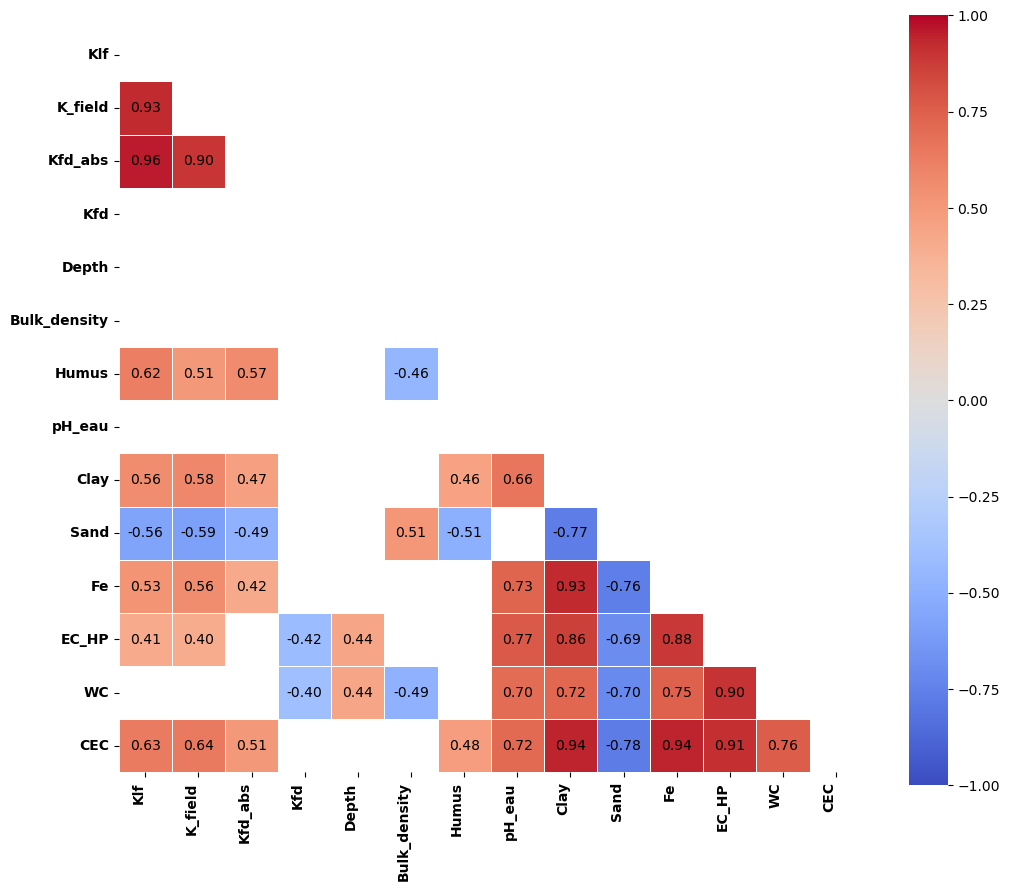

In [6]:
# Define the filtered features
filtered_features = ['Klf', 'K_field', 'Kfd_abs', 'Kfd', 'Depth', 'Bulk_density', 
                     'Humus', 'pH_eau', 'Clay', 'Sand', 'Fe', 'EC_HP', 'WC', 'CEC']

# Drop rows with NaN values in the filtered features to handle NaNs
df_filtered = df[filtered_features].dropna()

# Calculate the Spearman rank correlation coefficients and p-values
corr, p_value = spearmanr(df_filtered, nan_policy='omit')

# Convert to DataFrame for easier plotting
corr_df = pd.DataFrame(corr, index=filtered_features, columns=filtered_features)
p_value_df = pd.DataFrame(p_value, index=filtered_features, columns=filtered_features)

# Create a mask for significant p-values (e.g., p < 0.005)
p_value_mask = 0.005
significant_mask = p_value_df < p_value_mask

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Combine the masks
final_mask = mask | ~significant_mask

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=final_mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, vmin=-1, vmax=1, annot_kws={"size": 10, "color": "black"})

# Adjust layout for better readability
plt.xticks(rotation=90, ha='right', fontsize=10, fontweight='bold')
plt.yticks(rotation=0, fontsize=10, fontweight='bold')
#plt.title('Spearman Rank Correlation Heatmap showing significant P-Values < ' + str(p_value_mask), fontsize=12, fontweight='bold')

# Save the plot
folder_path = 'figures_output/'
filename = "Corr_Hysteresis.png"
plt.savefig(folder_path + filename, dpi=300)

# Show the plot
plt.show()

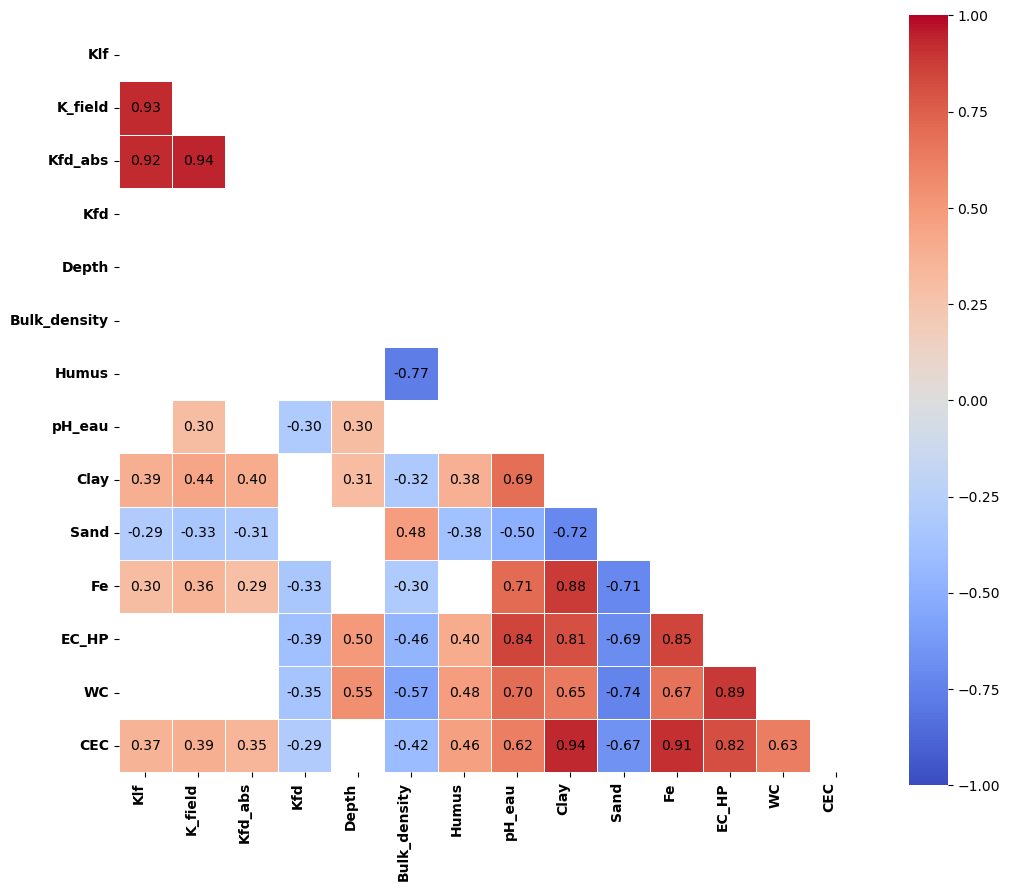

In [7]:
# Define the filtered features
filtered_features = ['Klf', 'K_field', 'Kfd_abs', 'Kfd', 'Depth', 'Bulk_density', 
                     'Humus', 'pH_eau', 'Clay', 'Sand', 'Fe', 'EC_HP', 'WC', 'CEC']

# Drop rows with NaN values in the filtered features to handle NaNs
df_filtered = df[filtered_features].dropna()

# Initialize matrices to store Pearson correlation coefficients and p-values
corr = np.zeros((len(filtered_features), len(filtered_features)))
p_value = np.zeros((len(filtered_features), len(filtered_features)))

# Calculate the Pearson correlation coefficients and p-values
for i in range(len(filtered_features)):
    for j in range(len(filtered_features)):
        corr[i, j], p_value[i, j] = pearsonr(df_filtered.iloc[:, i], df_filtered.iloc[:, j])

# Convert to DataFrame for easier plotting
corr_df = pd.DataFrame(corr, index=filtered_features, columns=filtered_features)
p_value_df = pd.DataFrame(p_value, index=filtered_features, columns=filtered_features)

# Create a mask for significant p-values (e.g., p < 0.0001)
p_value_mask = 0.05
significant_mask = p_value_df < p_value_mask

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Combine the masks
final_mask = mask | ~significant_mask

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=final_mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, vmin=-1, vmax=1, annot_kws={"size": 10, "color": "black"})

# Adjust layout for better readability
plt.xticks(rotation=90, ha='right', fontsize=10, fontweight='bold')
plt.yticks(rotation=0, fontsize=10, fontweight='bold')
#plt.title('Pearson Correlation Heatmap showing significant P-Values < ' + str(p_value_mask), fontsize=12, fontweight='bold')

# Save the plot
folder_path = 'figures_output/'
filename = "Corr_Hysteresis.png"
plt.savefig(folder_path + filename, dpi=300)

# Show the plot
plt.show()

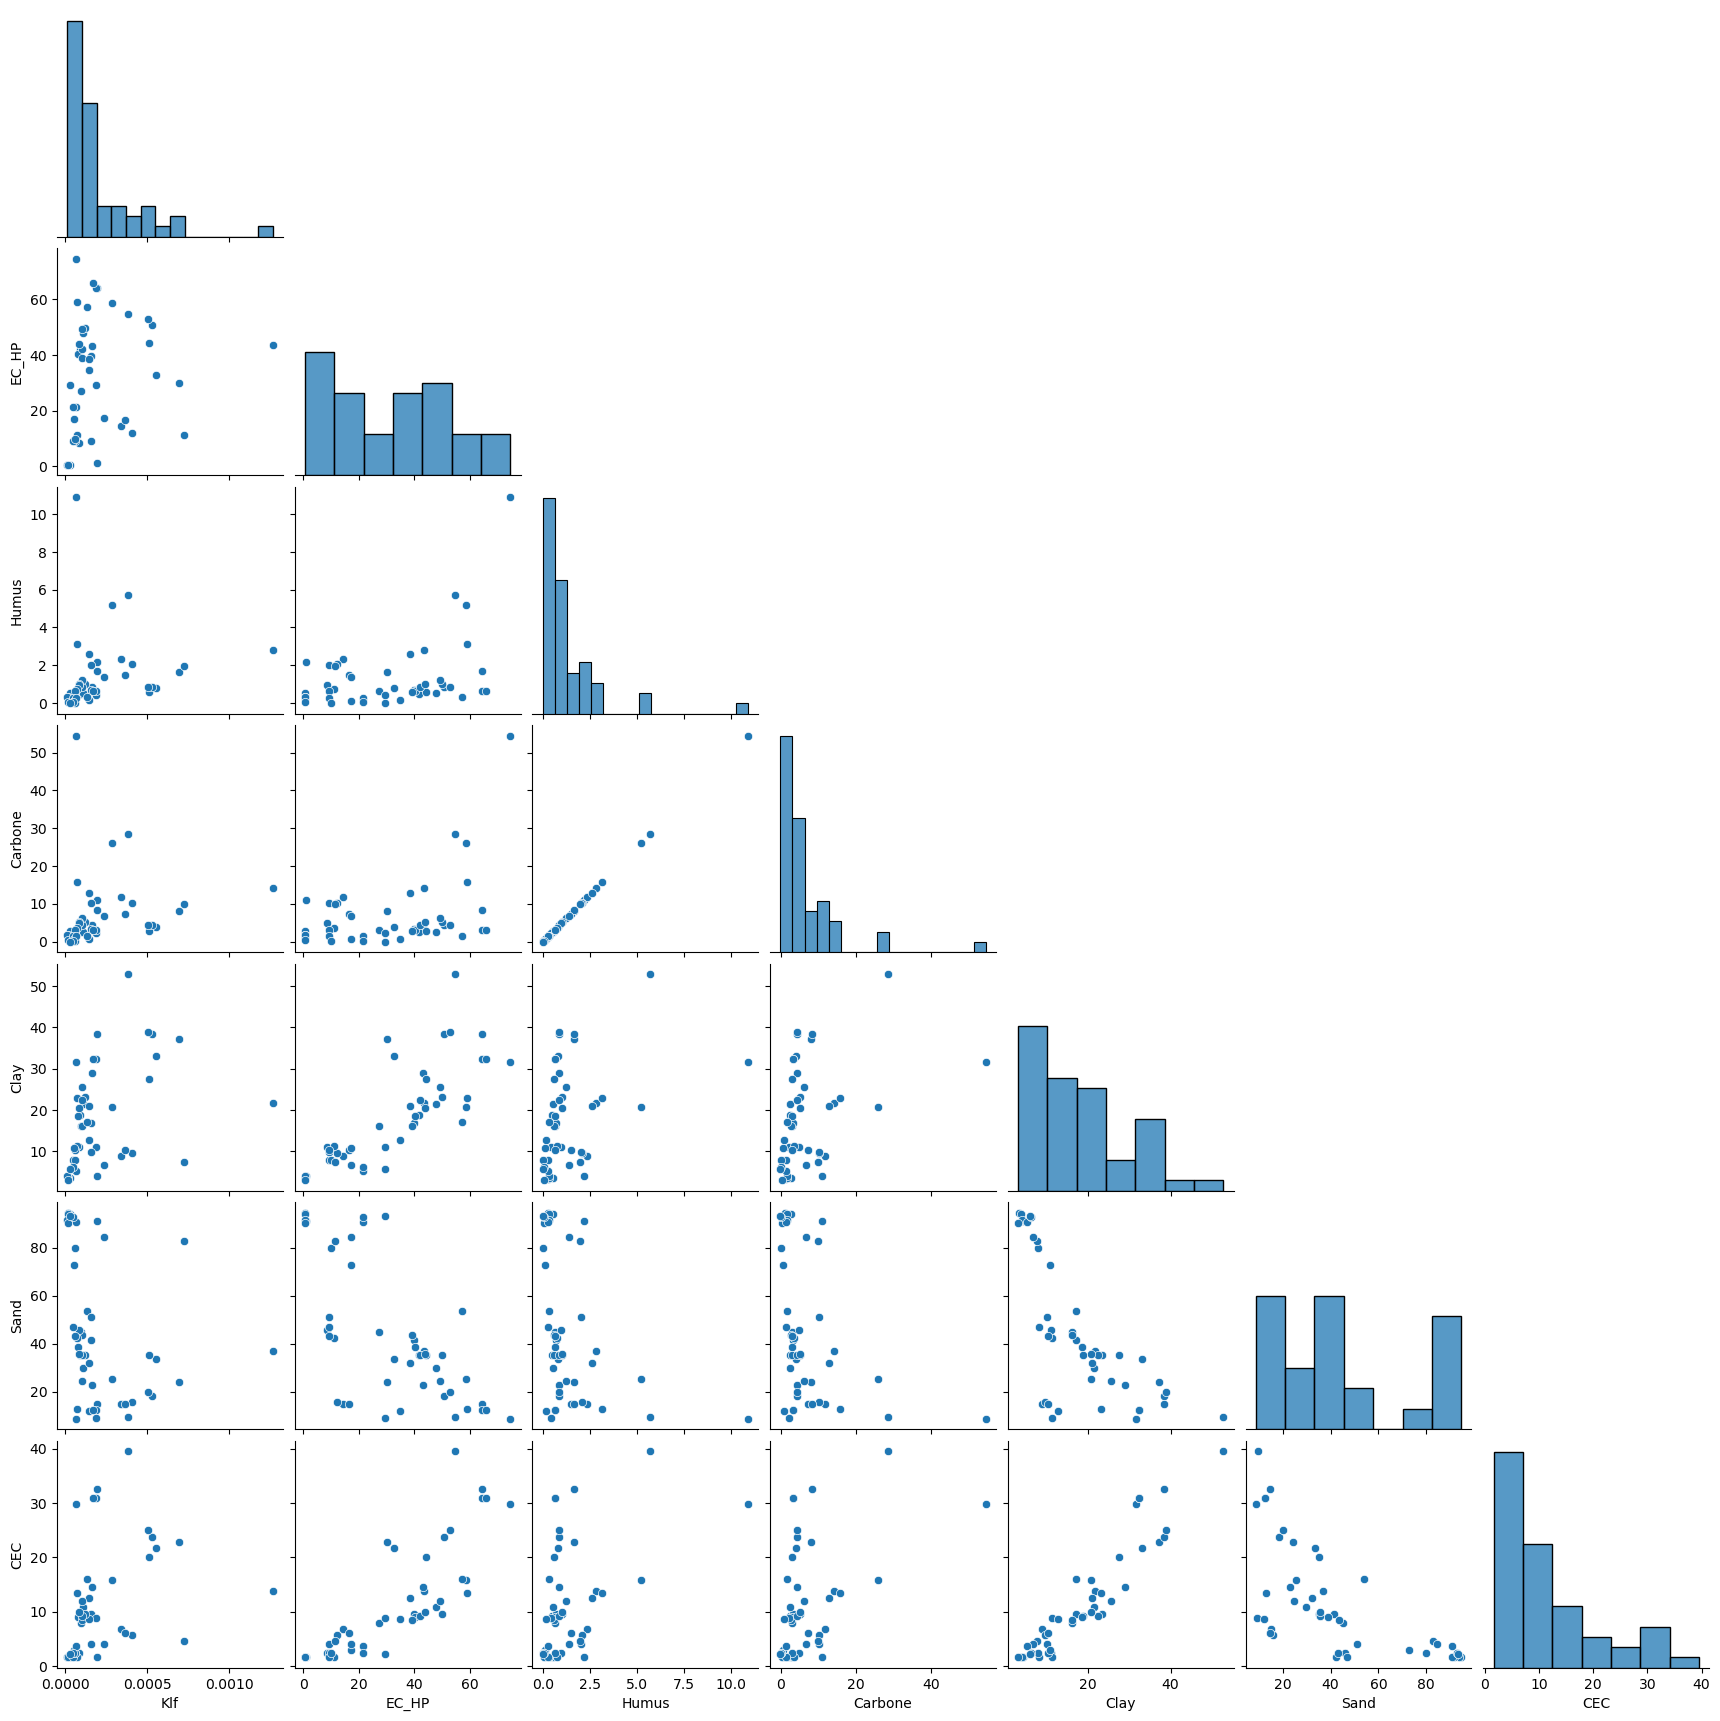

In [8]:
g = sns.pairplot(df.loc[:,['Klf', 'EC_HP', 'Humus', 'Carbone', 'Clay', 'Sand', 'CEC']], 
                  diag_kws=dict(fill=True), corner=True)
plt.show()

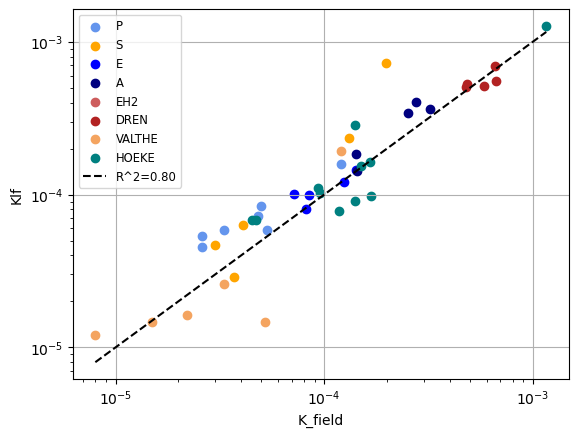

In [9]:
mapping = {
    # "AN": ("black", "o"),
    "P": ("cornflowerblue", "o"),
    "S": ("orange", "o"),
    "E": ("blue", "o"),
    "A": ("navy", "o"),
    "EH2": ("indianred", "o"),
  # "L": ("burlywood", "o"),
    "DREN": ("firebrick", "o"),
    "VALTHE": ("sandybrown", "o"),
    "HOEKE": ("teal", "o"),
#    "EHBH": ("seagreen", "o"),
}

plot_sing(df, 'K_field', 'Klf', mapping, onexone_line=True, log_scale=True)

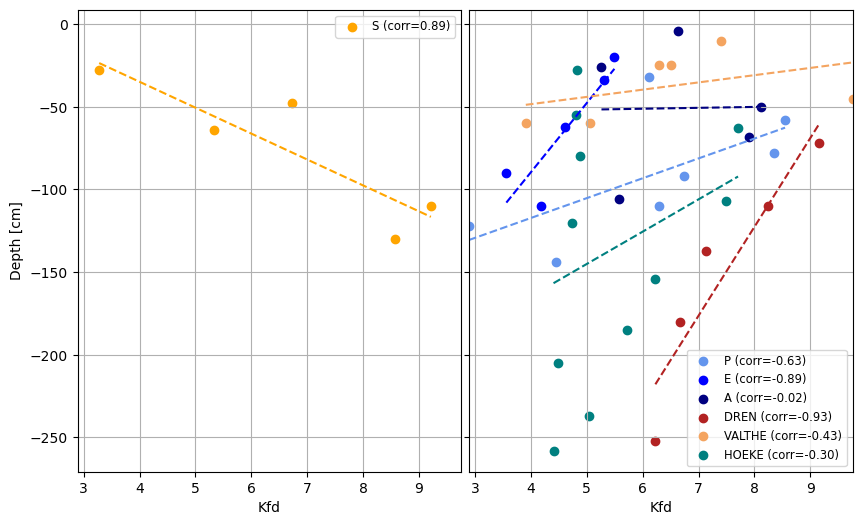

In [10]:
def plot_kfdepth(df, var1, var2, mapping, onexone_line=False, log_scale=False):
    # Drop rows where either var1 or var2 has NaN values
    df_clean = df.dropna(subset=[var1, var2])

    # Create a figure with two subplots sharing the y-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
    fig.subplots_adjust(wspace=0.02)  # Adjust the space between the subplots

    # Variables to store min and max for Kfd (var1)
    kfd_min, kfd_max = float('inf'), float('-inf')

    for start_str, (color, marker) in mapping.items():
        mask = df_clean['SAMPLE'].str.startswith(start_str) & df_clean[var1].notna() & df_clean[var2].notna()
        filtered_df = df_clean[mask]

        if filtered_df.empty:
            continue

        # Update min and max for Kfd to ensure consistent scale
        kfd_min = min(kfd_min, filtered_df[var1].min())
        kfd_max = max(kfd_max, filtered_df[var1].max())

        # Linear regression to find the trend
        X = filtered_df[var1].values.reshape(-1, 1)
        Y = filtered_df[var2].values
        reg = LinearRegression().fit(X, Y)
        trend = reg.coef_[0]

        # Calculate Pearson correlation coefficient
        corr, _ = pearsonr(filtered_df[var1], filtered_df[var2])

        # Generate linear trend line
        x_range = np.linspace(min(X), max(X), 100)
        y_trend_line = reg.predict(x_range.reshape(-1, 1))

        # Determine which subplot to use based on the trend
        if trend > 0:
            # Plot data points and trend line in the left subplot
            ax1.scatter(filtered_df[var1], -filtered_df[var2], color=color, marker=marker, label=f'{start_str} (corr={corr:.2f})')
            ax1.plot(x_range, -y_trend_line, color=color, linestyle='--')
        else:
            # Plot data points and trend line in the right subplot
            ax2.scatter(filtered_df[var1], -filtered_df[var2], color=color, marker=marker, label=f'{start_str} (corr={corr:.2f})')
            ax2.plot(x_range, -y_trend_line, color=color, linestyle='--')

    # Set properties for both subplots
    for ax in [ax1, ax2]:
        ax.set_xlabel(var1)
        if ax == ax1:
            ax.set_ylabel('Depth [cm]')
        ax.grid(True)
        ax.legend(fontsize='small')

        if log_scale:
            ax.set_xscale('log')
            ax.set_yscale('log')

        # Invert the Y-axis for depth from maximum to zero
        ax.invert_yaxis()

    # Set the same x-axis limits for both subplots for Kfd
    ax1.set_xlim(kfd_min, kfd_max)
    ax2.set_xlim(kfd_min, kfd_max)

    # Ensure the output directory exists
    folder_path = 'figures_output/'
    os.makedirs(folder_path, exist_ok=True)
    filename = f"{var1}_{var2}_{'log' if log_scale else 'linear'}_subplots.png"
    plt.savefig(folder_path + filename)

    plt.show()

# Example usage
plot_kfdepth(df, 'Kfd', 'Depth', mapping)

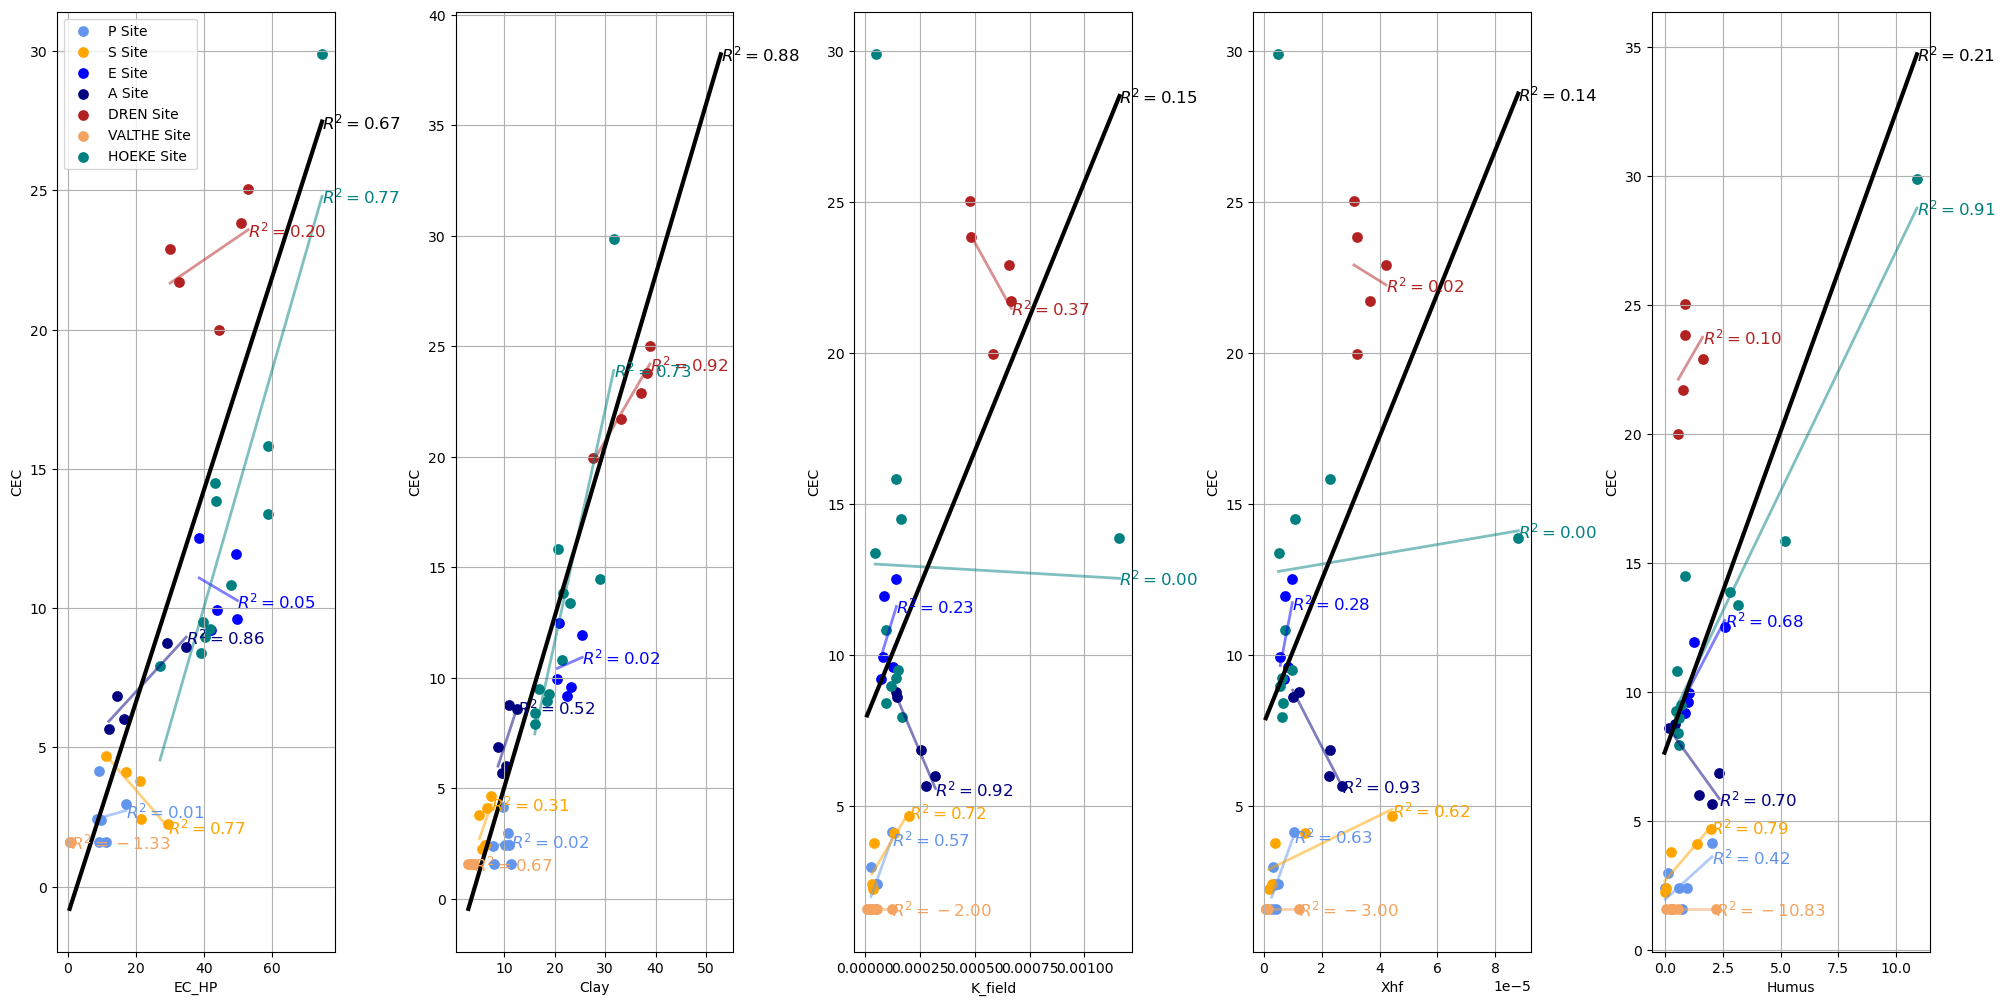

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(20, 10))

# First row plots using df
# Plot scatter and regression lines for EC_HP vs CEC
plot_data1(axs[0], df, 'EC_HP', 'CEC', mapping, include_label=True)
axs[0].set_xlabel('EC_HP')
axs[0].set_ylabel('CEC')
axs[0].grid(True)

# Plot scatter and regression lines for Clay vs CEC
plot_data1(axs[1], df, 'Clay', 'CEC', mapping, include_label=False)
axs[1].set_xlabel('Clay')
axs[1].set_ylabel('CEC')
axs[1].grid(True)

# Plot scatter and regression lines for Fe vs CEC
plot_data1(axs[2], df, 'K_field', 'CEC', mapping, include_label=False)
axs[2].set_xlabel('K_field')
axs[2].set_ylabel('CEC')
axs[2].grid(True)

# Plot scatter and regression lines for Xhf vs CEC
plot_data1(axs[3], df, 'Xhf', 'CEC', mapping, include_label=False)
axs[3].set_xlabel('Xhf')
axs[3].set_ylabel('CEC')
axs[3].grid(True)

# Plot scatter and regression lines for Xhf vs CEC
plot_data1(axs[4], df, 'Humus', 'CEC', mapping, include_label=False)
axs[4].set_xlabel('Humus')
axs[4].set_ylabel('CEC')
axs[4].grid(True)

plt.tight_layout(pad=.50)  # Reduced padding between subplots
plt.show()

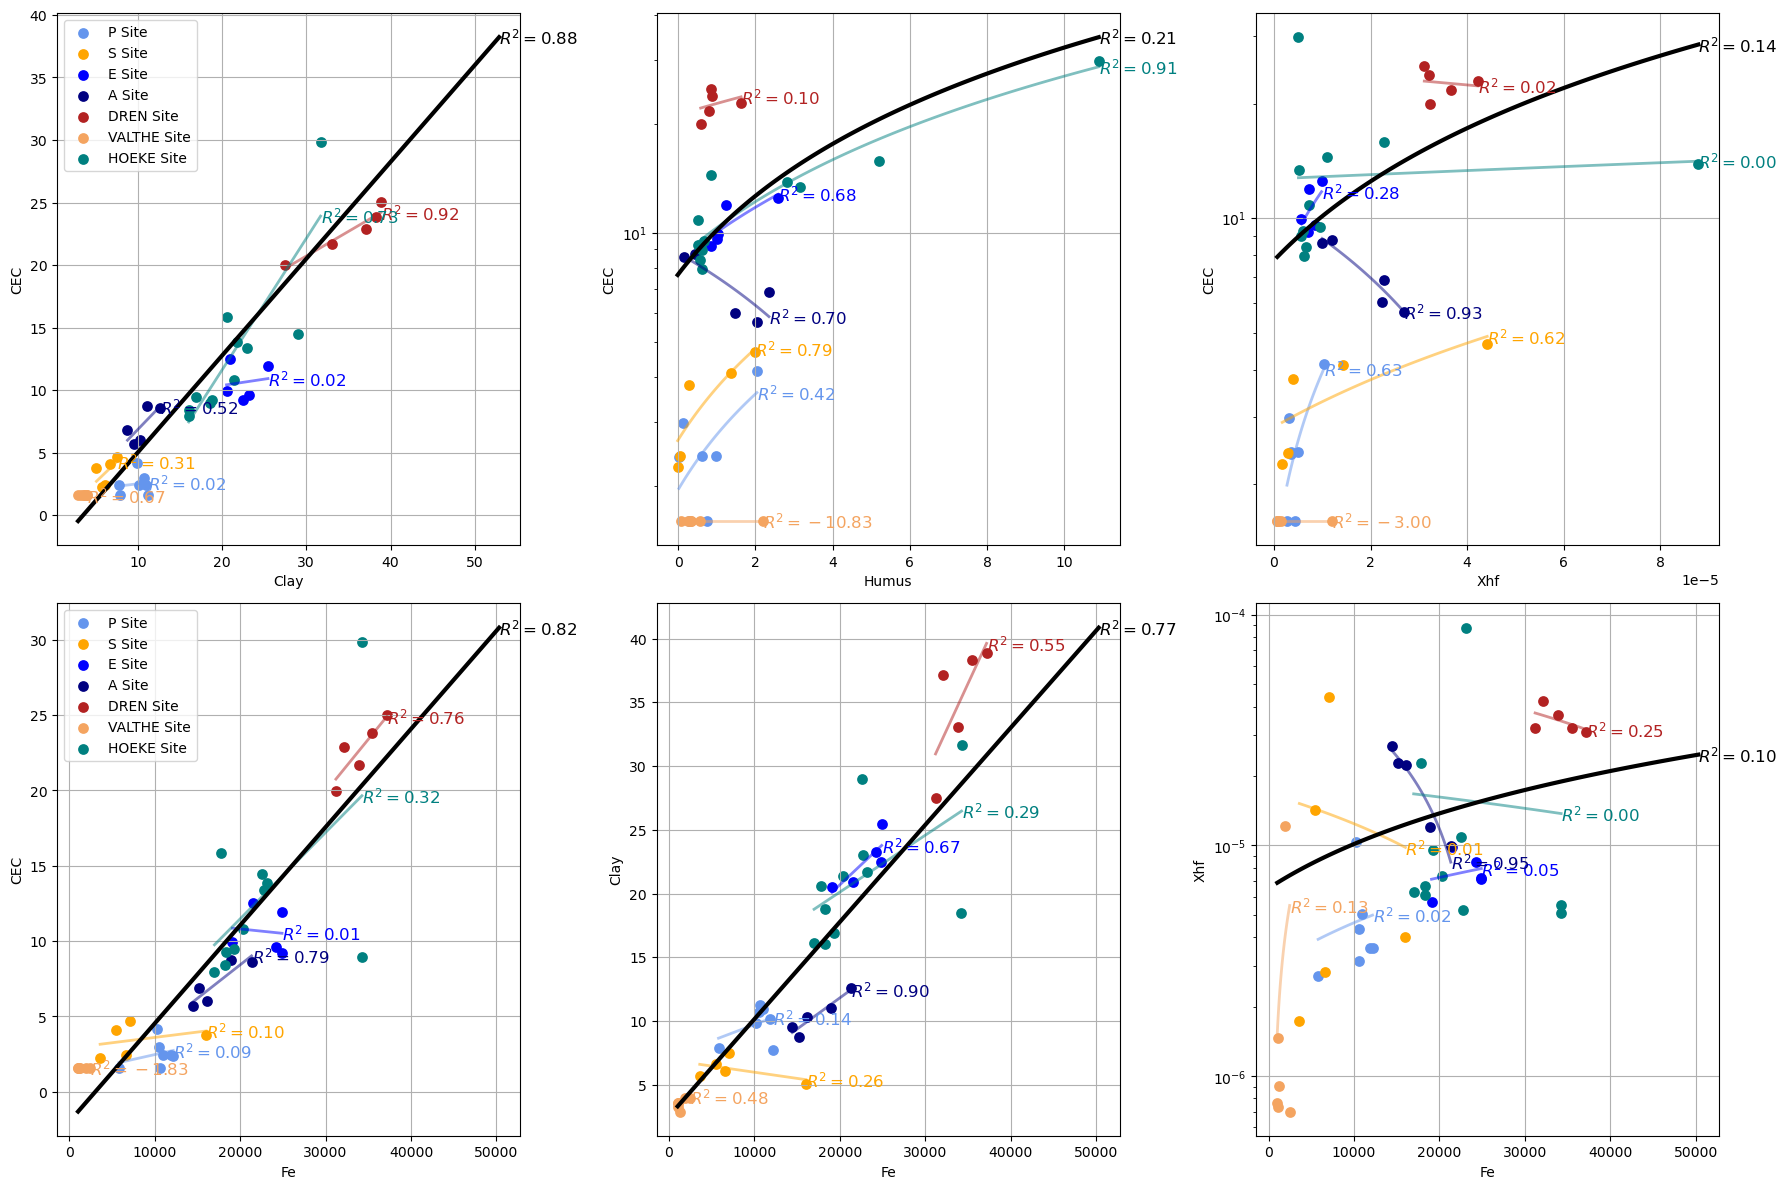

In [12]:
# Extract columns for plotting
x_col_clay = 'Clay'
y_col_cec = 'CEC'
x_col_Xhf = 'Xhf'
x_col_ec_hp = 'EC_HP'
x_col_fe = 'Fe'
x_col_humus = 'Humus'

fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# First row plots using df
# Plot scatter and regression lines for Clay vs CEC
plot_data1(axs[0, 0], df, x_col_clay, y_col_cec, mapping, include_label=True)
axs[0, 0].set_xlabel('Clay')
axs[0, 0].set_ylabel('CEC')
axs[0, 0].grid(True)

# Plot scatter and regression lines for Clay vs Xhf
plot_data1(axs[0, 1], df, x_col_humus, y_col_cec, mapping, include_label=False)
axs[0, 1].set_xlabel('Humus')
axs[0, 1].set_ylabel('CEC')
axs[0, 1].grid(True)
axs[0, 1].set_yscale('log')

# Plot scatter and regression lines for CEC vs Xhf
plot_data1(axs[0, 2], df, x_col_Xhf, y_col_cec, mapping, include_label=False)
axs[0, 2].set_ylabel('CEC')
axs[0, 2].set_xlabel('Xhf')
axs[0, 2].grid(True)
axs[0, 2].set_yscale('log')

# Second row plots using dff
# Plot scatter and regression lines for Clay vs EC_HP
plot_data1(axs[1, 0], df, x_col_fe, y_col_cec, mapping, include_label=True)
axs[1, 0].set_xlabel('Fe')
axs[1, 0].set_ylabel('CEC')
axs[1, 0].grid(True)

# Plot scatter and regression lines for CEC vs EC_HP
plot_data1(axs[1, 1], df, x_col_fe, x_col_clay, mapping, include_label=False)
axs[1, 1].set_xlabel('Fe')
axs[1, 1].set_ylabel('Clay')
axs[1, 1].grid(True)

# Plot scatter and regression lines for Xhf vs EC_HP
plot_data1(axs[1, 2], df, x_col_fe, x_col_Xhf, mapping, include_label=False)
axs[1, 2].set_ylabel('Xhf')
axs[1, 2].set_xlabel('Fe')
axs[1, 2].grid(True)
axs[1, 2].set_yscale('log')

plt.tight_layout()
plt.show()

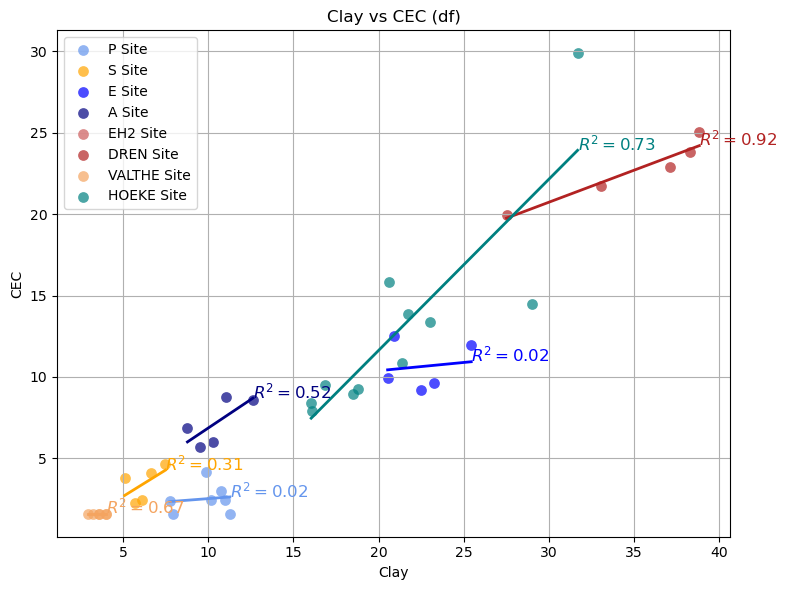

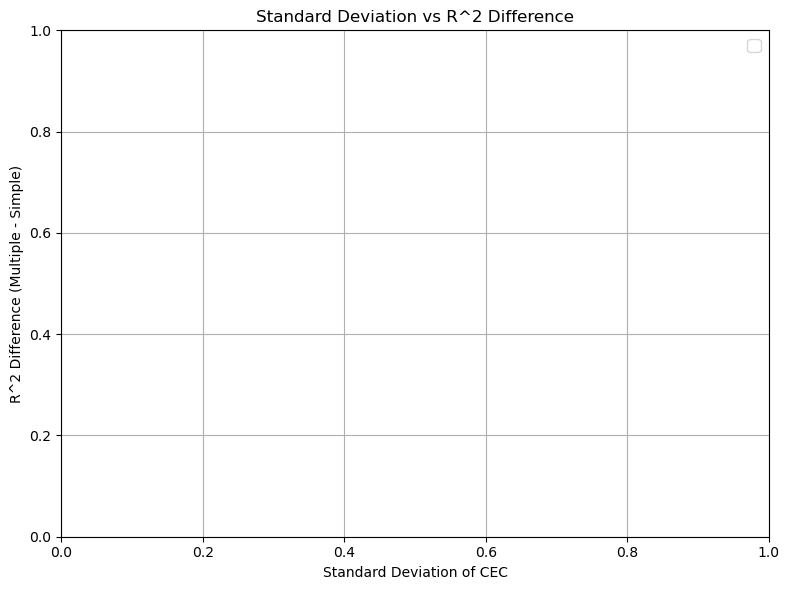

In [13]:
# Extract columns for plotting
x_col_clay = 'Clay'
y_col_cec = 'CEC'

fig, ax = plt.subplots(figsize=(8, 6))

# Plot scatter and regression lines for Clay vs CEC
std_devs, r2_diffs = plot_data2(ax, df, x_col_clay, y_col_cec, mapping, include_label=True)
ax.set_xlabel('Clay')
ax.set_ylabel('CEC')
ax.set_title('Clay vs CEC (df)')
ax.grid(True)

plt.tight_layout()
plt.show()

# Plot standard deviation versus R^2 difference
fig, ax2 = plt.subplots(figsize=(8, 6))
for start_str, (color, marker) in mapping.items():
    for std, r2_diff in zip(std_devs, r2_diffs):
        if start_str in df['SAMPLE'].unique():
            label = f"{start_str} Site" if True else None
            ax2.scatter(std, r2_diff, color=color, s=100, label=label)
            ax2.text(std, r2_diff, start_str, fontsize=12, color=color)

ax2.set_xlabel('Standard Deviation of CEC')
ax2.set_ylabel('R^2 Difference (Multiple - Simple)')
ax2.set_title('Standard Deviation vs R^2 Difference')
ax2.grid(True)

# Add legend
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=12)

plt.tight_layout()
plt.show()

## Linear implementation to predict CEC 
## No train-test


In [14]:
results_r2 = pd.DataFrame(columns=['Clay_Klf', 'Clay_Kfd'])
results_rmse = pd.DataFrame(columns=['Clay_Klf', 'Clay_Kfd'])

In [15]:
# Define feature sets for regressions
#feature_sets_1 = [('Clay',), ('K_field',), ('Clay', 'Sand'), ('Clay', 'Klf'), ('Clay', 'K_field'), ('Clay', 'Humus')]

#feature_sets_1 = [('Clay',), ('Humus',), ('K_field',), ('EC1_5',), ('Humus', 'Khf'), ('Clay', 'Humus'), #['Clay', 'pH_eau'], ('Clay', 'Khf'), 
#    ('Clay', 'K_field'), ('Clay', 'Humus', 'Khf'), ('Clay', 'Sand', 'Humus')]


target_1 = 'CEC'
#feature_sets_2 = [('Clay',), ('Clay', 'CEC'), ('Clay', 'Sand'), ('Clay', 'Humus')]
#target_2 = 'Klf'

# Define your df, feature_sets_1, and feature_sets_2 as before

# Find the best regressor and its features for each target
##best_reg_1, best_features_1 = perform_regression_and_select_best(feature_sets_1, target_1, df)
#best_reg_2, best_features_2 = perform_regression_and_select_best(feature_sets_2, target_2, df)

# Generate meshgrids and Z values for the best regressor of each set
##X1, Y1, Z1 = generate_meshgrid_and_Z(best_reg_1, df, best_features_1)
#X2, Y2, Z2 = generate_meshgrid_and_Z(best_reg_2, df, best_features_2)

# Interactive plots
##def interactive_plot_1(elev=30, azim=30):
##    plot_3d(df, best_features_1[0], best_features_1[1], target_1, X1, Y1, Z1, elev, azim)

#def interactive_plot_2(elev=30, azim=30):
#    plot_3d(df, best_features_2[0], best_features_2[1], target_2, X2, Y2, Z2, elev, azim)

# Display interactive widgets
##display(widgets.interactive(interactive_plot_1, elev=(0, 90, 2), azim=(0, 360, 2)))
#display(widgets.interactive(interactive_plot_2, elev=(0, 90, 2), azim=(0, 360, 2)))
# Here we implemented linear functions to predict soil CEC based on different features. The model development fits the entire dataset.
# With these trhee conditions, adding soil susceptibility to clay is the optimal for CEC prediction.
# Further analysis follows the same problem for non-linear modelling with split of train and test datasets

## CEC prediction with Train-Test for all samples

1 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 1 0.843 0.884 3.623 3.325 ['Clay']
2 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 2 0.398 0.51 7.302 6.755 ['Sand']
3 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 2 0.133 0.276 8.858 8.304 ['K_field']
4 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 2 0.059 0.295 9.49 8.139 ['Khf']
5 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 1 0.004 0.07 9.381 9.385 ['Kfd']
6 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 1 0.021 0.125 9.218 9.089 ['Kfd_abs']
7 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 1 -0.029 0.073 9.334 9.435 ['Depth']
8 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 1 0.009 0.185 9.152 8.806 ['Bulk_density']
9 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_trai

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


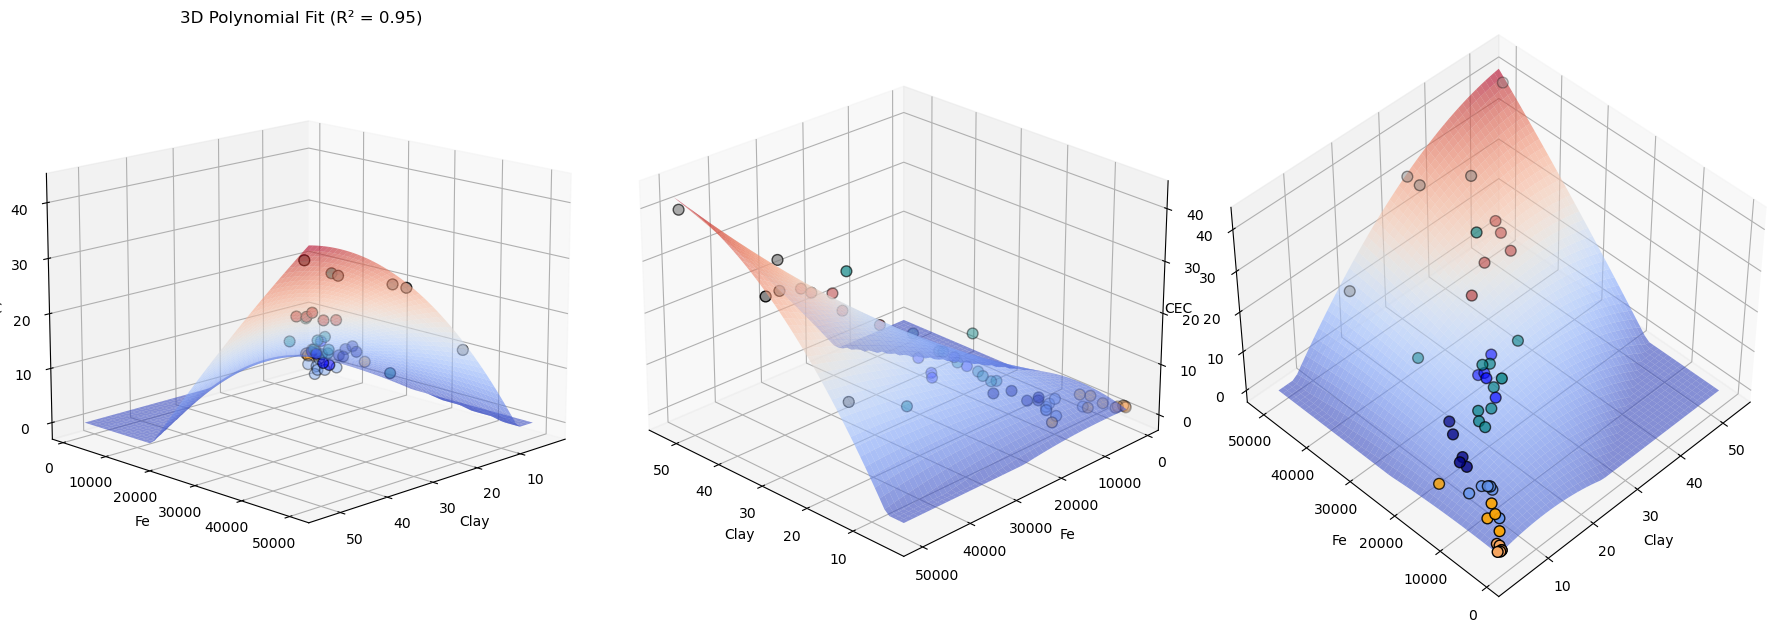

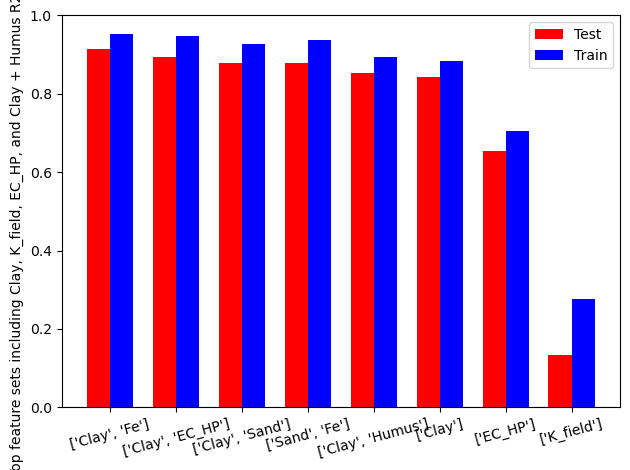

In [16]:
feature_sets_CEC = [
    ['Clay'],
    ['Sand'],
    ['K_field'],
    ['Khf'],
    ['Kfd'],
    ['Kfd_abs'],
    ['Depth'],
    ['Bulk_density'],
    ['Humus'],
    ['Fe'],
    ['EC_HP'],
    ['pH_eau'],
    ['WC']
]
i =1
n=4 # How many feature combinations are shown in the horizontal bar plots

# Generate all pairs of features
pair_combinations = list(itertools.combinations([f[0] for f in feature_sets_CEC], 2))

# Convert pairs to the same format as individual features
feature_sets_pairs = [[pair[0], pair[1]] for pair in pair_combinations]

# Combine individual features and pairs into one list
all_feature_sets = feature_sets_CEC + feature_sets_pairs

df_CEC = df['CEC']

# Prepare to store the results for all feature sets
results_summary = []
test_errors_summary = []
train_errors_summary = []
best_n_ = []

# Evaluate all feature sets
for feature_set in all_feature_sets:
    best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol = stochastic_poly(df, feature_set, df_CEC, iters=100)
    print(i, 'best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set:', best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set)
    
    # Store results in lists for later use
    best_n_.append(best_n)
    test_errors_summary.append(R2_test_pol)
    train_errors_summary.append(R2_train_pol)
    
    # Also store the results in a structured format for sorting
    results_summary.append({
        'feature_set': feature_set,
        'best_n': best_n,
        'R2_test_pol': R2_test_pol,
        'R2_train_pol': R2_train_pol,
        'RMSE_test_pol': RMSE_test_pol,
        'RMSE_train_pol': RMSE_train_pol
    })
    i+=1
# Keep the lists of feature sets, test errors, and train errors as they are for further use
best_feat_ind = test_errors_summary.index(max(test_errors_summary))
best_feat = all_feature_sets[best_feat_ind]  # Use all_feature_sets to match the order
best_feat_n = best_n_[best_feat_ind]
print('best_feat_ind, best_feat, best_feat_n', best_feat_ind, best_feat, best_feat_n)

# This part remains the same: finding the best feature set and using it in `fit_and_plot`
fit_and_plot(df, best_feat, 'CEC', best_feat_n, mapping)

# Convert the results summary to a DataFrame for sorting and filtering
results_df = pd.DataFrame(results_summary)


# Sort by R2_test_pol in descending order and select the top 4
top_results = results_df.sort_values(by='R2_test_pol', ascending=False).head(n)

# Ensure that 'Clay', 'K_field', 'EC_HP', and 'Clay + Humus' are included
required_features = [['Clay'], ['K_field'], ['EC_HP'], ['Clay', 'Humus']]

# Find the corresponding results for the required features in the original results
for required in required_features:
    required_result = results_df[results_df['feature_set'].apply(lambda x: set(x) == set(required))]
    
    # Append the result for the required feature if it's not already in the top results
    if not required_result.empty and not any(set(required_result['feature_set'].values[0]) == set(x) for x in top_results['feature_set'].values):
        top_results = pd.concat([top_results, required_result])

# Now we ensure that the top 4 feature sets along with the required features are included in the plot
# Sort by R2_test_pol in descending order again to maintain consistency
top_results = top_results.sort_values(by='R2_test_pol', ascending=False)

# Plot the updated top results, which include the top 4 feature sets, and 'Clay', 'K_field', 'EC_HP', and 'Clay + Humus'
bars_plot(top_results['feature_set'].tolist(), 
          top_results['R2_test_pol'].tolist(), 
          top_results['R2_train_pol'].tolist(), 
          'Top feature sets including Clay, K_field, EC_HP, and Clay + Humus')

# CEC prediction with Train and Test for Sandy

In [17]:
# Drop rows with NaN values in the filtered features to handle NaNs
df_filtered = sandy_soil[filtered_features].dropna()

# Calculate the Spearman rank correlation coefficients and p-values
corr, p_value = spearmanr(df_filtered, nan_policy='omit')

# Convert to DataFrame for easier plotting
correlation_matrix = pd.DataFrame(corr, index=filtered_features, columns=filtered_features)

print("Correlation Matrix:\n", correlation_matrix)

# Multiple regression
X = sm.add_constant(sandy_soil[['K_field', 'Clay']])

# Check VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

Correlation Matrix:
                    Klf   K_field   Kfd_abs       Kfd     Depth  Bulk_density  \
Klf           1.000000  0.892438  0.971538 -0.042308 -0.299788     -0.459231   
K_field       0.892438  1.000000  0.883972 -0.018472 -0.403157     -0.483741   
Kfd_abs       0.971538  0.883972  1.000000  0.146923 -0.314412     -0.505385   
Kfd          -0.042308 -0.018472  0.146923  1.000000 -0.033096     -0.346923   
Depth        -0.299788 -0.403157 -0.314412 -0.033096  1.000000      0.433327   
Bulk_density -0.459231 -0.483741 -0.505385 -0.346923  0.433327      1.000000   
Humus         0.736154  0.679238  0.743077  0.113077 -0.675775     -0.560769   
pH_eau        0.260870  0.290664  0.245479 -0.103886  0.175168      0.329357   
Clay          0.521538  0.500674  0.502308 -0.017692  0.360593     -0.111538   
Sand         -0.656154 -0.629209 -0.643077  0.046923 -0.153935      0.396154   
Fe            0.591538  0.583414  0.550769 -0.132308  0.324803     -0.103077   
EC_HP         0.444

best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 1 0.407 0.531 1.854 1.669 ['Clay']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 1 0.463 0.497 1.788 1.719 ['Sand']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 2 0.458 0.59 1.847 1.517 ['K_field']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 2 0.033 0.417 2.363 1.84 ['Khf']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.092 0.0 2.535 2.473 ['Kfd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 2 0.13 0.332 2.344 1.976 ['Kfd_abs']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.092 0.0 2.535 2.473 ['Depth']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.092 0.0 2.535 2.473 ['Bulk_density']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names



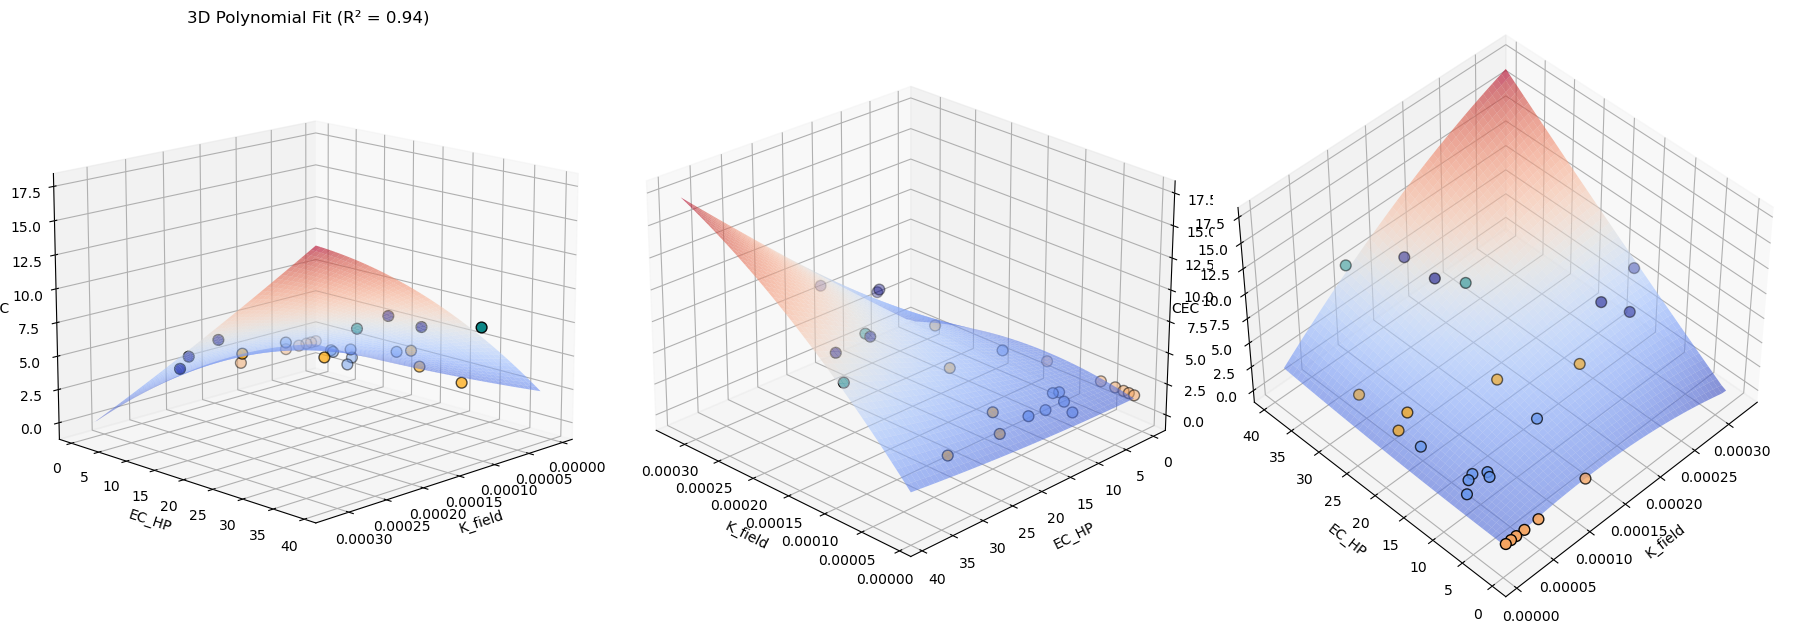

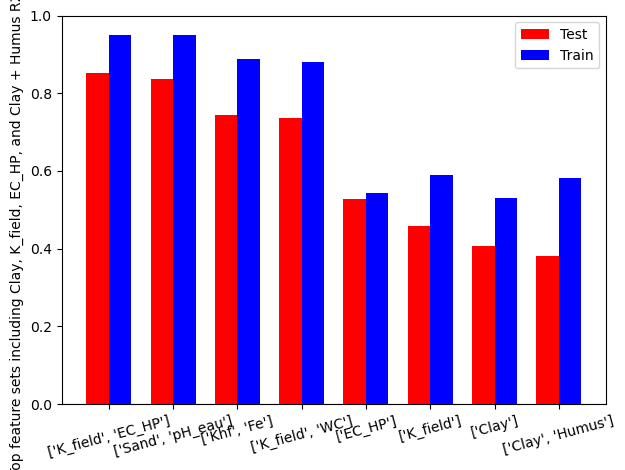

In [18]:
sandy_test_errors_summary = []
sandy_train_errors_summary = []
best_n_sandy = []
sandy_results_summary = []

# Evaluate all feature sets
for feature_set in all_feature_sets:
    best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol = stochastic_poly(sandy_soil, feature_set, sandy_soil['CEC'], iters=100)
    print('best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set:', best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set)
    
    # Store results in lists for later use
    best_n_sandy.append(best_n)
    sandy_test_errors_summary.append(R2_test_pol)
    sandy_train_errors_summary.append(R2_train_pol)
    
    # Also store the results in a structured format for sorting
    sandy_results_summary.append({
        'feature_set': feature_set,
        'best_n': best_n,
        'R2_test_pol': R2_test_pol,
        'R2_train_pol': R2_train_pol,
        'RMSE_test_pol': RMSE_test_pol,
        'RMSE_train_pol': RMSE_train_pol
    })

# Keep the lists of feature sets, test errors, and train errors as they are for further use
best_feat_ind = sandy_test_errors_summary.index(max(sandy_test_errors_summary))
best_feat = all_feature_sets[best_feat_ind]  # Use all_feature_sets to match the order
best_feat_n = best_n_sandy[best_feat_ind]
print('best_feat_ind, best_feat, best_feat_n', best_feat_ind, best_feat, best_feat_n)

# This part remains the same: finding the best feature set and using it in `fit_and_plot`
fit_and_plot(sandy_soil, best_feat, 'CEC', best_feat_n, mapping)

# Convert the results summary to a DataFrame for sorting and filtering
results_sandy = pd.DataFrame(sandy_results_summary)




# Sort by R2_test_pol in descending order and select the top 4
top_results_sandy = results_sandy.sort_values(by='R2_test_pol', ascending=False).head(n)

# Ensure that 'Clay', 'K_field', 'EC_HP', and 'Clay + Humus' are included
required_features = [['Clay'], ['K_field'], ['EC_HP'], ['Clay', 'Humus']]

# Find the corresponding results for the required features in the original results
for required in required_features:
    required_result = results_sandy[results_sandy['feature_set'].apply(lambda x: set(x) == set(required))]
    
    # Append the result for the required feature if it's not already in the top results
    if not required_result.empty and not any(set(required_result['feature_set'].values[0]) == set(x) for x in top_results_sandy['feature_set'].values):
        top_results_sandy = pd.concat([top_results_sandy, required_result])

# Now we ensure that the top 4 feature sets along with the required features are included in the plot
# Sort by R2_test_pol in descending order again to maintain consistency
top_results_sandy = top_results_sandy.sort_values(by='R2_test_pol', ascending=False)

# Plot the updated top results, which include the top 4 feature sets, and 'Clay', 'K_field', 'EC_HP', and 'Clay + Humus'
bars_plot(top_results_sandy['feature_set'].tolist(), 
          top_results_sandy['R2_test_pol'].tolist(), 
          top_results_sandy['R2_train_pol'].tolist(), 
          'Top feature sets including Clay, K_field, EC_HP, and Clay + Humus')

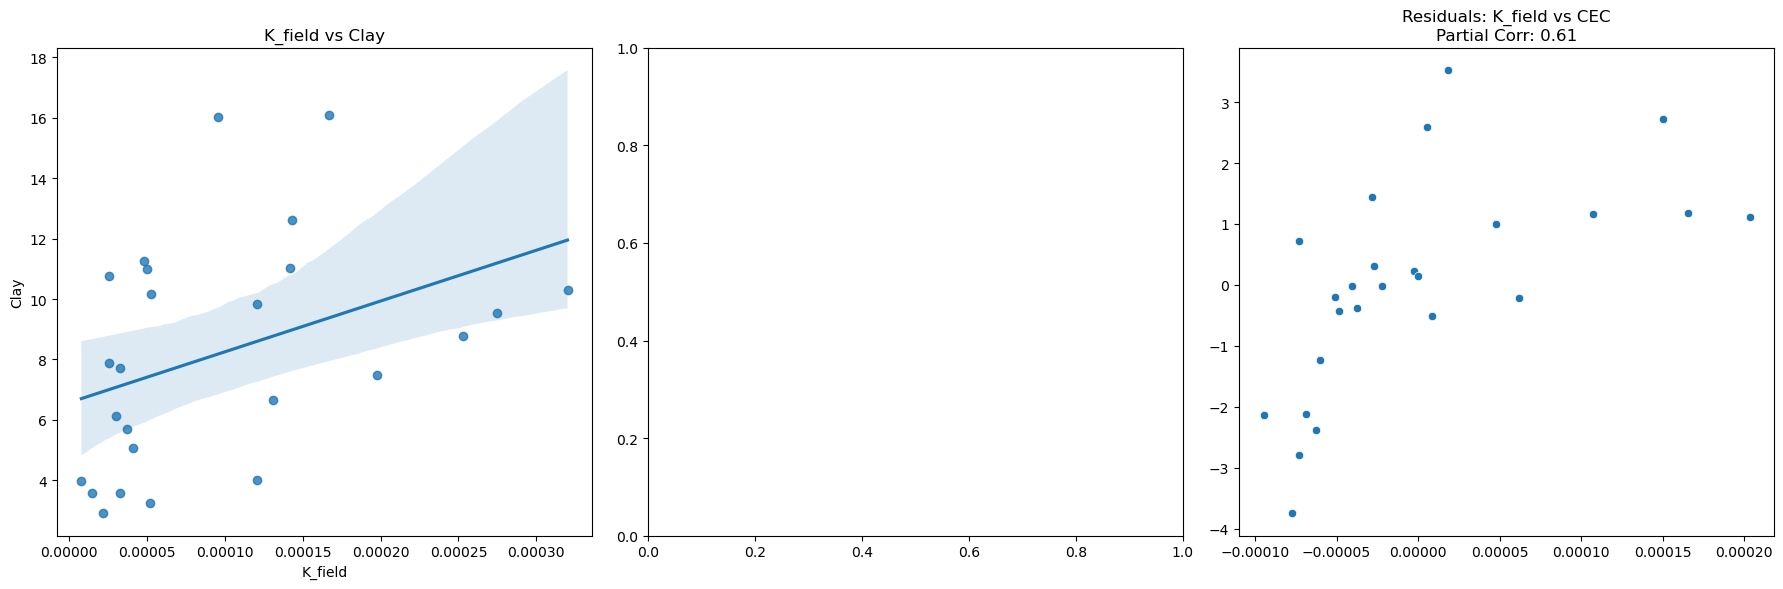

0.611721871467568

In [19]:
#partial_correlation(sandy_soil, 'K_field', 'CEC', 'Clay')
#artial_correlation(sandy_soil, 'K_field', 'CEC', 'Fe')

partial_correlation(sandy_soil, 'K_field', 'CEC', ['Clay'])

# CEC prediction with Train and Test for Clayey

Correlation Matrix:
                    Klf   K_field   Kfd_abs       Kfd     Depth  Bulk_density  \
Klf           1.000000  0.915144  0.942559  0.350435 -0.217051      0.570124   
K_field       0.915144  1.000000  0.898519  0.473020 -0.236831      0.607835   
Kfd_abs       0.942559  0.898519  1.000000  0.588338 -0.199391      0.631991   
Kfd           0.350435  0.473020  0.588338  1.000000  0.169639      0.634486   
Depth        -0.217051 -0.236831 -0.199391  0.169639  1.000000     -0.109637   
Bulk_density  0.570124  0.607835  0.631991  0.634486 -0.109637      1.000000   
Humus         0.067421 -0.084676  0.060949 -0.214006 -0.111401     -0.244942   
pH_eau       -0.334788 -0.256981 -0.319372 -0.095031 -0.215657      0.079791   
Clay          0.527506  0.445049  0.398694 -0.003914 -0.078312      0.106568   
Sand         -0.121331 -0.059848  0.019151  0.260491 -0.102676      0.415398   
Fe            0.283478  0.234117  0.109661 -0.297391 -0.079600      0.030876   
EC_HP        -0.127

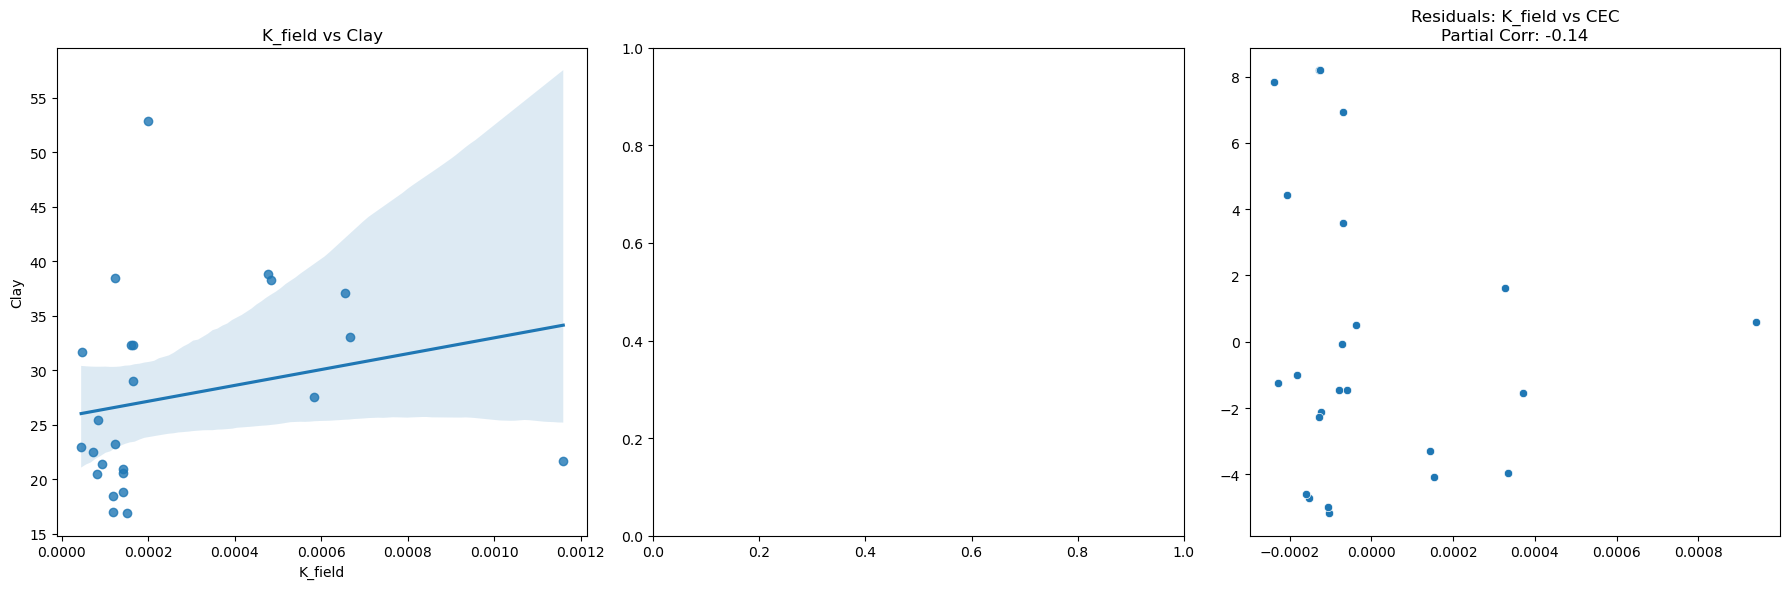

                            OLS Regression Results                            
Dep. Variable:                    CEC   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     35.72
Date:                Thu, 03 Oct 2024   Prob (F-statistic):           1.74e-07
Time:                        10:01:25   Log-Likelihood:                -68.613
No. Observations:                  24   AIC:                             143.2
Df Residuals:                      21   BIC:                             146.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.7238      3.041     -1.882      0.0

In [20]:
# Drop rows with NaN values in the filtered features to handle NaNs
df_filtered = clayey_soil[filtered_features].dropna()

# Calculate the Spearman rank correlation coefficients and p-values
corr, p_value = spearmanr(df_filtered, nan_policy='omit')

# Convert to DataFrame for easier plotting
correlation_matrix = pd.DataFrame(corr, index=filtered_features, columns=filtered_features)

print("Correlation Matrix:\n", correlation_matrix)

#partial_correlation(clayey_soil, 'K_field', 'CEC', 'Clay')
#partial_correlation(clayey_soil, 'K_field', 'CEC', 'Fe')

partial_correlation(clayey_soil, 'K_field', 'CEC', ['Clay'])
# Multiple regression
X = sm.add_constant(clayey_soil[['K_field', 'Clay']])
model = sm.OLS(clayey_soil['CEC'], X).fit()
print(model.summary())

# Check VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 1 0.664 0.782 4.502 4.241 ['Clay']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 2 0.461 0.684 6.115 4.957 ['Sand']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.113 0.0 8.661 9.045 ['K_field']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.113 0.0 8.661 9.045 ['Khf']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.113 0.0 8.661 9.045 ['Kfd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.113 0.0 8.661 9.045 ['Kfd_abs']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.113 0.0 8.661 9.045 ['Depth']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.113 0.0 8.661 9.045 ['Bulk_density']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names



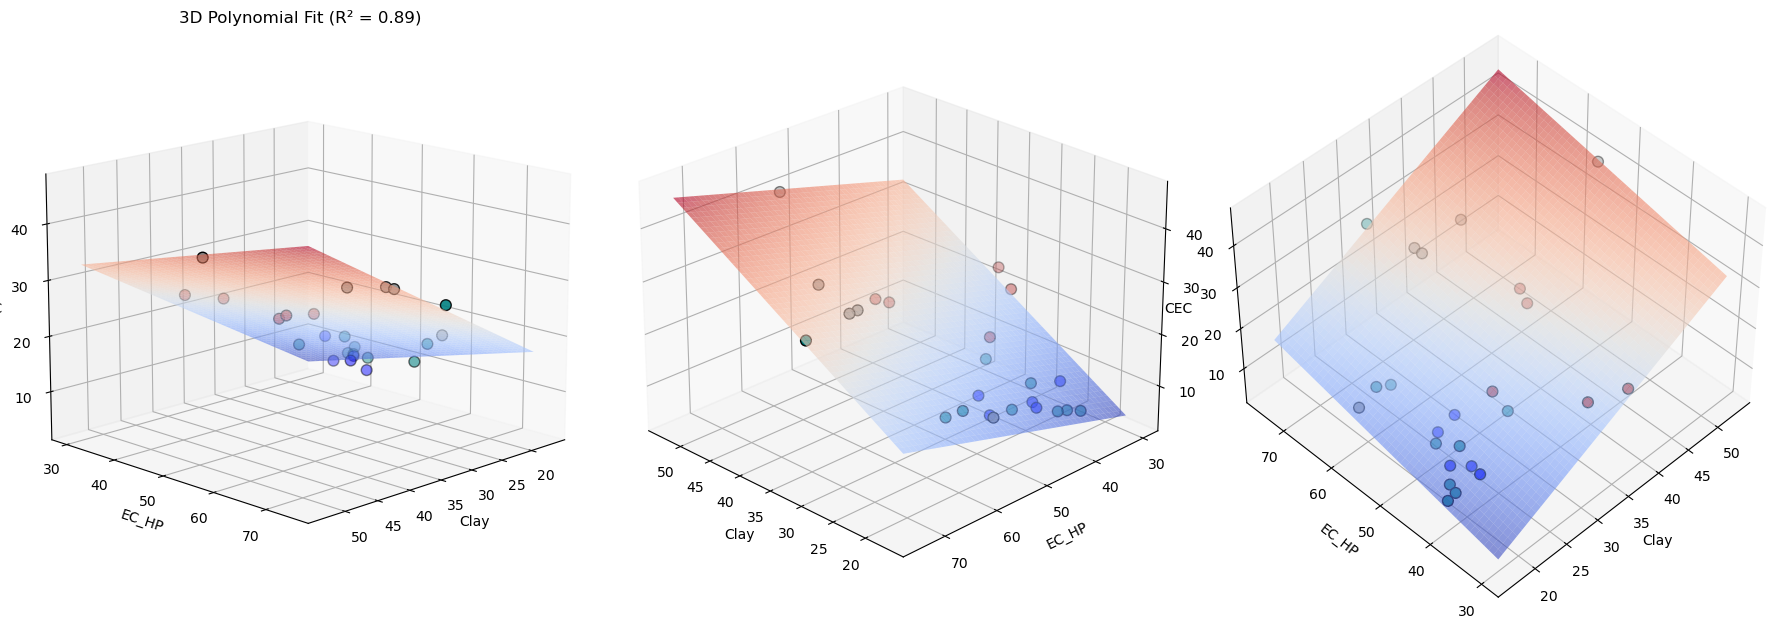

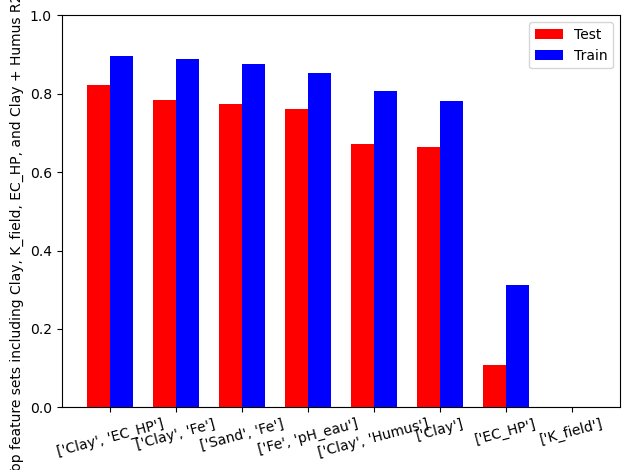

In [21]:
clayey_test_errors_summary = []
clayey_train_errors_summary = []
best_n_clayey = []
clayey_results_summary = []

# Evaluate all feature sets
for feature_set in all_feature_sets:
    best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol = stochastic_poly(clayey_soil, feature_set, clayey_soil['CEC'], iters=100)
    print('best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set:', best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set)
    
    # Store results in lists for later use
    best_n_clayey.append(best_n)
    clayey_test_errors_summary.append(R2_test_pol)
    clayey_train_errors_summary.append(R2_train_pol)
    
    # Also store the results in a structured format for sorting
    clayey_results_summary.append({
        'feature_set': feature_set,
        'best_n': best_n,
        'R2_test_pol': R2_test_pol,
        'R2_train_pol': R2_train_pol,
        'RMSE_test_pol': RMSE_test_pol,
        'RMSE_train_pol': RMSE_train_pol
    })

# Keep the lists of feature sets, test errors, and train errors as they are for further use
best_feat_ind = clayey_test_errors_summary.index(max(clayey_test_errors_summary))
best_feat = all_feature_sets[best_feat_ind]  # Use all_feature_sets to match the order
best_feat_n = best_n_clayey[best_feat_ind]
print('best_feat_ind, best_feat, best_feat_n', best_feat_ind, best_feat, best_feat_n)

# This part remains the same: finding the best feature set and using it in `fit_and_plot`
fit_and_plot(clayey_soil, best_feat, 'CEC', best_feat_n, mapping)

# Convert the results summary to a DataFrame for sorting and filtering
results_clayey = pd.DataFrame(clayey_results_summary)


# Sort by R2_test_pol in descending order and select the top 4
top_results_clayey = results_clayey.sort_values(by='R2_test_pol', ascending=False).head(n)

# Ensure that 'Clay', 'K_field', 'EC_HP', and 'Clay + Humus' are included
required_features = [['Clay'], ['K_field'], ['EC_HP'], ['Clay', 'Humus']]

# Find the corresponding results for the required features in the original results
for required in required_features:
    required_result = results_clayey[results_clayey['feature_set'].apply(lambda x: set(x) == set(required))]
    
    # Append the result for the required feature if it's not already in the top results
    if not required_result.empty and not any(set(required_result['feature_set'].values[0]) == set(x) for x in top_results_clayey['feature_set'].values):
        top_results_clayey = pd.concat([top_results_clayey, required_result])

# Now we ensure that the top 4 feature sets along with the required features are included in the plot
# Sort by R2_test_pol in descending order again to maintain consistency
top_results_clayey = top_results_clayey.sort_values(by='R2_test_pol', ascending=False)

# Plot the updated top results, which include the top 4 feature sets, and 'Clay', 'K_field', 'EC_HP', and 'Clay + Humus'
bars_plot(top_results_clayey['feature_set'].tolist(), 
          top_results_clayey['R2_test_pol'].tolist(), 
          top_results_clayey['R2_train_pol'].tolist(), 
          'Top feature sets including Clay, K_field, EC_HP, and Clay + Humus')

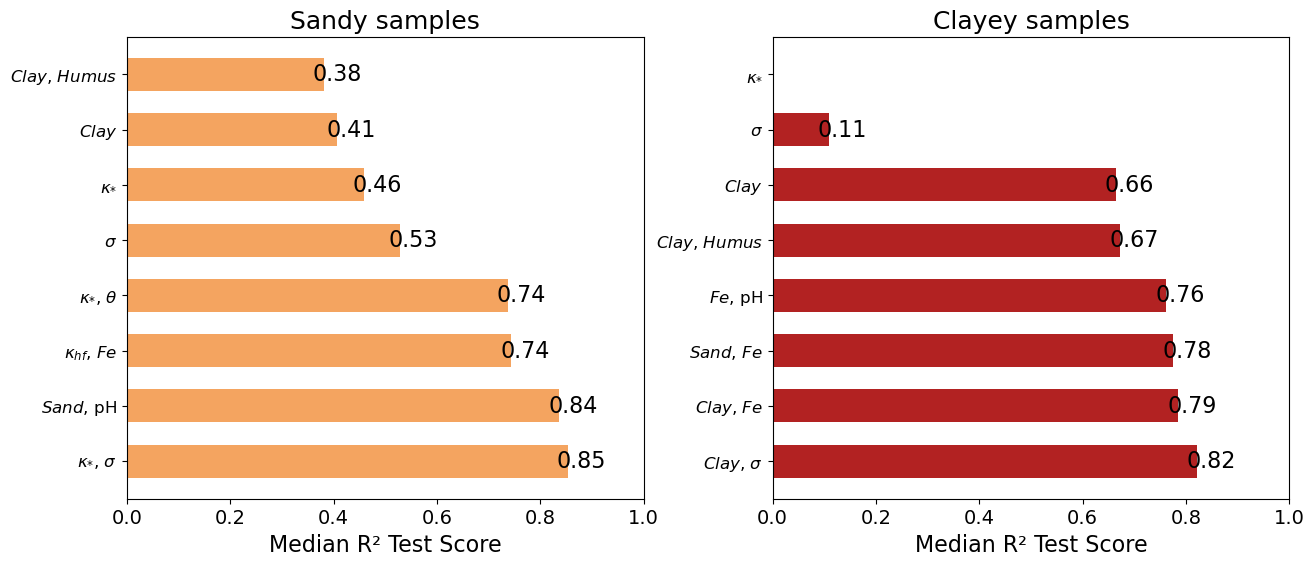

In [22]:
# Define your feature sets and new labels for single features
feature_sets_CEC = [
    ['Clay'], ['Sand'], ['K_field'], ['Khf'], ['Kfd'], ['Kfd_abs'],
    ['Depth'], ['Bulk_density'], ['Humus'], ['Fe'], ['EC_HP'], ['pH_eau'], ['WC']
]

new_labels = [
    r'$\it{Clay}$', r'$\it{Sand}$', r'$\it{\kappa_{*}}$', r'$\it{\kappa_{hf}}$', 
    r'$\it{\kappa_{fd}}$', r'$\it{\kappa_{fd\,abs}}$', r'$\it{Depth}$', r'$\it{b_d}$', 
    r'$\it{Humus}$', r'$\it{Fe}$', r'$\it{\sigma}$', 'pH', r'$\it{\theta}$'
]

# Create a mapping for single features
single_features = [f[0] for f in feature_sets_CEC]
single_feature_to_label = {f: label for f, label in zip(single_features, new_labels)}

# Generate all pairs of features
pair_combinations = list(itertools.combinations(single_features, 2))

# Convert pairs to the same format as individual features
feature_sets_pairs = [[pair[0], pair[1]] for pair in pair_combinations]

# Generate labels for feature pairs by combining individual labels
pair_labels = []
for pair in feature_sets_pairs:
    label1 = single_feature_to_label.get(pair[0], pair[0])
    label2 = single_feature_to_label.get(pair[1], pair[1])
    pair_label = f'{label1}, {label2}'
    pair_labels.append(pair_label)

# Combine individual features and pairs into one list
all_feature_sets = feature_sets_CEC + feature_sets_pairs

# Extend new_labels to include labels for pairs
new_labels_extended = new_labels + pair_labels

# Create a dictionary to map feature sets to their corresponding labels
feature_to_label = {tuple(f): label for f, label in zip(all_feature_sets, new_labels_extended)}

# Reverse the order of feature sets and test errors if necessary
feature_sets_CEC = feature_sets_CEC[::-1]
# Assume sandy_test_errors_summary and clayey_test_errors_summary are defined and reversed if needed

# Assuming 'top_results_sandy' and 'top_results_clayey' contain feature_set info
n_sandy = len(top_results_sandy)  # Number of sandy test results
n_clayey = len(top_results_clayey)  # Number of clayey test results

# Define y positions for each set of features
y_sandy = np.arange(n_sandy)  # Label locations for sandy features
y_clayey = np.arange(n_clayey)  # Label locations for clayey features
height = 0.6  # Bar height

# Ensure the feature sets in 'top_results_sandy' and 'top_results_clayey' are tuples
top_results_sandy_features = [tuple(fs) for fs in top_results_sandy.feature_set]
top_results_clayey_features = [tuple(fs) for fs in top_results_clayey.feature_set]

# Use the mapping to get the correct labels
sandy_labels = [feature_to_label.get(fs, "Unknown") for fs in top_results_sandy_features]
clayey_labels = [feature_to_label.get(fs, "Unknown") for fs in top_results_clayey_features]

# Set font sizes globally
plt.rcParams.update({'font.size': 16})

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.25)

# Plot for sandy soil
rects1 = ax1.barh(y_sandy, top_results_sandy.R2_test_pol, height, color='sandybrown')
ax1.set_xlabel('Median R² Test Score', fontsize=16)
ax1.set_title('Sandy samples', fontsize=18)
ax1.set_yticks(y_sandy)
ax1.set_yticklabels(sandy_labels, fontsize=12)
ax1.set_xlim(0, 1)
ax1.tick_params(axis='x', labelsize=14)

# Plot for clayey soil
rects2 = ax2.barh(y_clayey, top_results_clayey.R2_test_pol, height, color='firebrick')
ax2.set_xlabel('Median R² Test Score', fontsize=16)
ax2.set_title('Clayey samples', fontsize=18)
ax2.set_yticks(y_clayey)
ax2.set_yticklabels(clayey_labels, fontsize=12)
ax2.set_xlim(0, 1)
ax2.tick_params(axis='x', labelsize=14)

# Function to add labels on bars
def add_labels(rects, ax):
    for rect in rects:
        width = rect.get_width()
        ax.annotate(f'{width:.2f}',
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(10, 0),  # 10 points horizontal offset
                    textcoords="offset points",
                    ha='center', va='center',
                    fontsize=16)

# Add the labels for both plots
add_labels(rects1, ax1)
add_labels(rects2, ax2)

# Save and show plot
plt.savefig('figures_output/barplot.png', dpi=300)
plt.show()

C:\Users\gmendoza\AppData\Local\Temp\ipykernel_18300\1463451523.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\gmendoza\AppData\Local\Temp\ipykernel_18300\1463451523.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



49
44


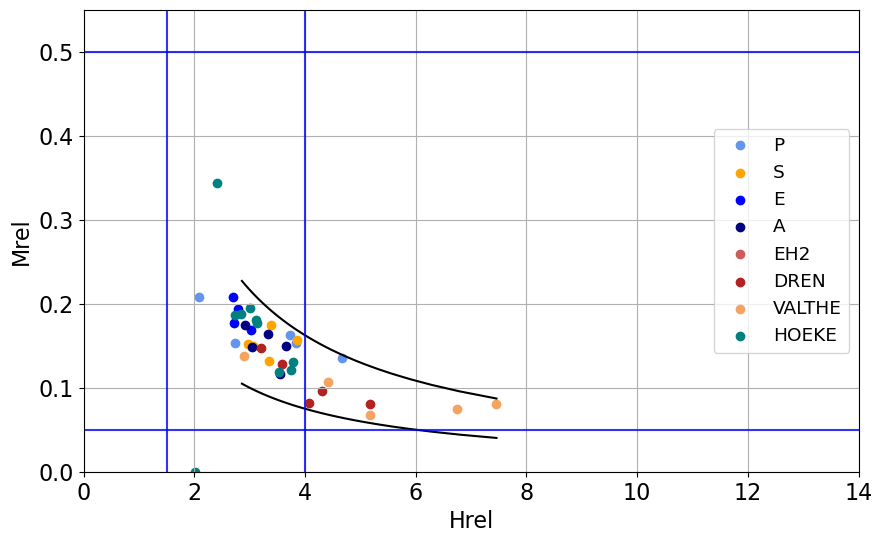

In [23]:
df['Hrel'] = df.Hcr/df.Hc
df['Mrel'] = df.Mrs/df.Ms
print(len(df.Mrel))
df = df[df.Hc > 0.0]
df = df[df.Hcr > 0.0]
print(len(df.Mrel))

def plot_day(df, var1, var2, mapping, onexone_line=False, log_scale=False):
    plt.figure(figsize=(10, 6))
    for start_str, (color, marker) in mapping.items():
        mask = df['SAMPLE'].str.startswith(start_str)
        filtered_df = df[mask]
        plt.scatter(filtered_df[var1], filtered_df[var2], color=color, marker=marker, label=start_str)
        plt.grid(True)

    r2 = r2_score(df[var1], df[var2])

    # Adding a 1:1 line
    if onexone_line:
        x = np.linspace(min(df[var1]), max(df[var1]), 100)
        plt.plot(x, x, color='black', linestyle='--', label=f'R^2={r2:.2f}' )

    # Setting both axes to logarithmic scale
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')    
        
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.legend(fontsize='small')  # Adjusting the font size of the legend

    sHc  = np.linspace(min(df['Hc']) , max(df['Hc']) , 100)
    sHcr = np.linspace(min(df['Hcr']), max(df['Hcr']), 100)

    p01 = 0.1 / (sHcr / sHc)
    p03 = 0.3 / (sHcr / sHc)
    p025 = 0.25 / (sHcr / sHc)
    p07 = 0.65 / (sHcr / sHc)

    #plt.plot(sHcr / sHc, p01, c="black", label="p01")
    plt.plot(sHcr / sHc, p03, c="black", label="p03")
    plt.plot(sHcr / sHc, p07, c="black", label="p07")

    plt.axvline(x=1.5, alpha=0.8, color='b')
    plt.axvline(x=4, alpha=0.8, color='b')
    plt.axhline(y=0.5, alpha=0.8, color='b')
    plt.axhline(y=0.05, alpha=0.8, color='b')

    #plt.axvline(x=5, color='deepskyblue')
    #plt.axhline(y=0.02, color='deepskyblue')
    plt.xlim(0, 14)
    plt.ylim(0, 0.55)

    folder_path = 'figures_output/'
    filename = var1 + '_' + var2 + '_' + str(log_scale) + ".png"
    plt.savefig(folder_path + filename)
    plt.show()
    
plot_day(df, 'Hrel', 'Mrel', mapping)

In [24]:
def fit_and_plot(df, x_cols, y_col, degree, mapping, ss=60, lw=0):
    x = df[x_cols]
    y = df[y_col]
    
    # Generate polynomial features
    poly = PolynomialFeatures(degree)
    x_poly = poly.fit_transform(x)
    
    # Fit a linear model
    model = LinearRegression()
    model.fit(x_poly, y)
    print(pd.DataFrame(zip(x_poly, model.coef_)))

    print('model.coef_', model.coef_)
    print('model.intercept_', model.intercept_)

    if len(x_cols) == 1:  # If there's only one predictor
        x_plot = np.linspace(x[x_cols[0]].min(), x[x_cols[0]].max(), 300).reshape(-1, 1)
        x_plot_poly = poly.transform(x_plot)
        y_plot = model.predict(x_plot_poly)
        y_plot = np.maximum(0, y_plot)  # Ensure y_plot is non-negative
        
        fig = go.Figure(data=[go.Scatter(x=x[x_cols[0]], y=y, mode='markers', name='Data points'),
                              go.Scatter(x=x_plot[:, 0], y=y_plot, mode='lines', name=f'Polynomial fit degree {degree}')])
        fig.update_layout(title='Polynomial Fit', xaxis_title=x_cols[0], yaxis_title=y_col, yaxis=dict(range=[0, max(y_plot)]))
        fig.show()
        
    elif len(x_cols) == 2:  # If there are two predictors
        # Generate grid for plots
        x0_range = np.linspace(x[x_cols[0]].min(), x[x_cols[0]].max(), 50)
        x1_range = np.linspace(x[x_cols[1]].min(), x[x_cols[1]].max(), 50)
        x0_grid, x1_grid = np.meshgrid(x0_range, x1_range)
        x_grid = np.c_[x0_grid.ravel(), x1_grid.ravel()]
        
        # Predict y values on grid
        x_grid_poly = poly.transform(x_grid)
        y_grid = model.predict(x_grid_poly).reshape(x0_grid.shape)
        y_grid = np.maximum(0, y_grid)  # Ensure y_grid is non-negative

        # Calculate R² score
        y_pred = model.predict(x_poly)
        r2 = r2_score(y, y_pred)
        
        # Assign color to each point based on mapping
        colors = []
        for sample in df['SAMPLE']:
            for start_str, (color, marker) in mapping.items():
                if sample.startswith(start_str):
                    colors.append(color)
                    break
            else:
                colors.append('gray')  # default color if no match
        
        # 3D surface plot with transparency and reversed color gradient
        fig = go.Figure(data=[
            go.Scatter3d(
                x=x[x_cols[0]], 
                y=x[x_cols[1]], 
                z=y, 
                mode='markers', 
                marker=dict(size=5, color=colors), 
                name='Data points'
            ),
            go.Surface(
                x=x0_range, 
                y=x1_range, 
                z=y_grid, 
                opacity=0.6,  # Adjust transparency here
                colorscale='Bluered_r',  # Reverse gradient from blue to red (yellow)
                name='Polynomial Surface'
            )
        ])
        
        fig.update_layout(
            title=f'3D Polynomial Fit (R² = {r2:.2f})',
            scene=dict(
                xaxis_title=x_cols[0], 
                yaxis_title=x_cols[1], 
                zaxis_title=y_col
            )
        )
        
        # Show the interactive figure
        fig.show()
        
        # Save high-resolution image
        pio.write_image(fig, '3D_Plot_High_Resolution.png', width=1920, height=1080, scale=3)
        
    # Create static images from different perspectives using Matplotlib
    fig_static, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': '3d'})

    # Set the color map for the surface plot to be similar to Plotly's color scale
    cmap = plt.get_cmap('coolwarm')

    # Plot data points and surface for all three perspectives
    # First perspective (default)
    axes[0].scatter(x[x_cols[0]], x[x_cols[1]], y, c=colors, s=ss, edgecolor='k')
    axes[0].plot_surface(x0_grid, x1_grid, y_grid, alpha=0.6, cmap=cmap)
    axes[0].view_init(elev=15, azim=45)
    axes[0].set_xlabel(x_cols[0])
    axes[0].set_ylabel(x_cols[1])
    axes[0].set_zlabel(y_col)
    axes[0].set_title(f"3D Polynomial Fit (R² = {r2:.2f})")

    # Second perspective (top view)
    axes[1].scatter(x[x_cols[0]], x[x_cols[1]], y, c=colors, s=ss, edgecolor='k')
    axes[1].plot_surface(x0_grid, x1_grid, y_grid, alpha=0.6, cmap=cmap)
    axes[1].view_init(elev=25, azim=135)
    axes[1].set_xlabel(x_cols[0])
    axes[1].set_ylabel(x_cols[1])
    axes[1].set_zlabel(y_col)

    # Third perspective (side view)
    axes[2].scatter(x[x_cols[0]], x[x_cols[1]], y, c=colors, s=ss, edgecolor='k')
    axes[2].plot_surface(x0_grid, x1_grid, y_grid, alpha=0.6, cmap=cmap)
    axes[2].view_init(elev=45, azim=225)
    axes[2].set_xlabel(x_cols[0])
    axes[2].set_ylabel(x_cols[1])
    axes[2].set_zlabel(y_col)

    plt.tight_layout()
    plt.show()